In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.interpolate import interp1d
from astropy.io import fits

# allow interactive plots
#%matplotlib widget

In [2]:
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 45238.93416
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True


In [3]:
WLMIN=3400. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=10600. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom
# from key numbers
Reff=642.3/2. # effective radius in cm
Seff= np.pi*Reff**2  # in cm2
print(Seff)
exptime=30.0

324015.4546769212


In [4]:
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m effective aperture 
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3400.0, Max: 10600.0, Num: None, Delta: 1.0, Log: False


# Define general paths 

In [192]:
outdir_plots0 = 'output_plots/'
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots0)
outdir_files = 'output_files/'
if os.path.exists(outdir_files)==False:
    os.mkdir(outdir_files)

# Define paths to spectral atlases 

In [5]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_dict = {
    'calspec':os.path.join(pysynphot_root_path,'calspec'),
    'bpgs':os.path.join(pysynphot_root_path,'grid/bpgs'),
    'jacoby':os.path.join(pysynphot_root_path,'grid/jacobi'),
    'pickles':os.path.join(pysynphot_root_path,'grid/pickles/dat_uvk')
}

atlas_dir = 'spectral_atlases/'
file_dict = {
    'calspec':'',
    'bpgs':os.path.join(atlas_dir,'atlas_bpgs.txt'),
    'jacoby':os.path.join(atlas_dir,'atlas_jacoby.txt'),
    'pickles':os.path.join(atlas_dir,'atlas_pickles.txt')
}


Define also the spectral types 

In [6]:
spectral_types = ['O','B','A','F','G','K','M']

# Select a spectral atlas 

<img align="center" src = Stellar_Classification_Chart.png width=750 style="padding: 10px"> 

https://upload.wikimedia.org/wikipedia/commons/3/37/Stellar_Classification_Chart.png

Options: 
* calspec (HST calibration spectra): work in progress, need to separate stars from AGNs and other sources 
* bpgs (Bruzual-Persson-Gunn-Stryker): 175 spectra 
* jacobi (Jacoby-Hunter-Christian): 161 spectra 
* pickles (Pickles): 131 spectra 

In [7]:
atlas_name = 'pickles'

atlas_path = path_dict[atlas_name]
atlas_file = file_dict[atlas_name]

# Find the spectra files and information 

In [8]:
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
atlas_seds = pd.read_csv(atlas_file)
atlas_seds

File Type      Teff     Name
0      pickles_uk_1.fits  O5V  39810.70  unknown
1      pickles_uk_2.fits  O9V  35481.40  unknown
2      pickles_uk_3.fits  B0V  28183.80  unknown
3      pickles_uk_4.fits  B1V  22387.20  unknown
4      pickles_uk_5.fits  B3V  19054.60  unknown
..                   ...  ...       ...      ...
126  pickles_uk_127.fits  G8I   4591.98  unknown
127  pickles_uk_128.fits  K2I   4255.98  unknown
128  pickles_uk_129.fits  K3I       NaN  unknown
129  pickles_uk_130.fits  K4I   3990.25  unknown
130  pickles_uk_131.fits  M2I   3451.44  unknown

[131 rows x 4 columns]

# Load with pysynphot the spectra from the selected atlas 

In [9]:
sed_list = np.array(atlas_seds['File'])

In [10]:
sed_dict = {}
type_dict = {}
for i,sed in enumerate(sed_list):
    #print('-------')
    #print(sed)
    spec_ = S.FileSpectrum(os.path.join(atlas_path,sed))
    sed_dict[sed[:-5]] = spec_
    type_dict[sed[:-5]] = atlas_seds['Type'][i]

Check the spectra were correctly loaded 

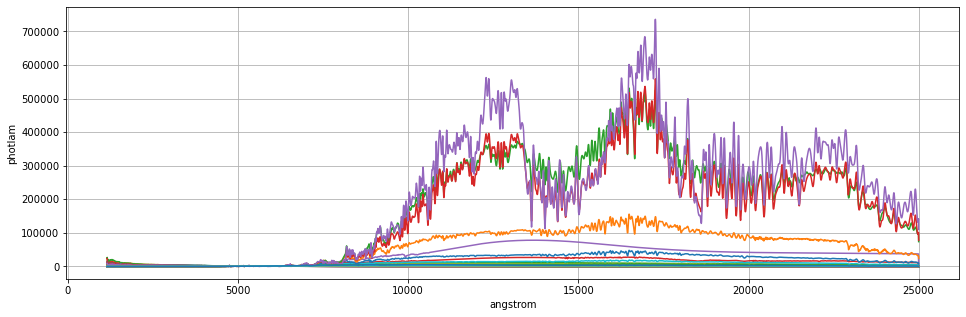

In [11]:
fig=plt.figure(figsize=(16,5))
for sed_ in sed_dict.keys():
    spec = sed_dict[sed_]
    spec.convert('photlam')
    plt.plot(spec.wave,spec.flux)
    plt.xlabel(spec.waveunits)
    plt.ylabel(spec.fluxunits)
    #plt.xlim((0,10000))
    plt.grid()


Let's organise spectra by spectral type 

In [12]:
spec_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    type_list_ = []
    spec_by_type[spec_type] = []
    for sed_ in type_dict.keys():
        if spec_type in type_dict[sed_]:
            type_list_.append(type_dict[sed_])
            spec_by_type[spec_type].append(sed_dict[sed_])
    print(spec_type, type_list_)
    print(len(type_list_))
    print('-----------')

O ['O5V', 'O9V', 'O8III']
3
-----------
B ['B0V', 'B1V', 'B3V', 'B57V', 'B8V', 'B9V', 'B2IV', 'B6IV', 'B12III', 'B3III', 'B5III', 'B9III', 'B2II', 'B5II', 'B0I', 'B1I', 'B3I', 'B5I', 'B8I']
19
-----------
A ['A0V', 'A2V', 'A3V', 'A5V', 'A7V', 'A0IV', 'A47IV', 'A0III', 'A3III', 'A5III', 'A7III', 'A0I', 'A2I']
13
-----------
F ['F0V', 'F2V', 'F5V', 'wF5V', 'F6V', 'rF6V', 'F8V', 'wF8V', 'rF8V', 'F02IV', 'F5IV', 'F8IV', 'F0III', 'F2III', 'F5III', 'F0II', 'F2II', 'F0I', 'F5I', 'F8I']
20
-----------
G ['G0V', 'wG0V', 'rG0V', 'G2V', 'G5V', 'wG5V', 'rG5V', 'G8V', 'G0IV', 'G2IV', 'G5IV', 'G8IV', 'G0III', 'G5III', 'wG5III', 'rG5III', 'G8III', 'wG8III', 'G5II', 'G0I', 'G2I', 'G5I', 'G8I']
23
-----------
K ['K0V', 'rK0V', 'K2V', 'K3V', 'K4V', 'K5V', 'K7V', 'K0IV', 'K1IV', 'K3IV', 'K0III', 'wK0III', 'rK0III', 'K1III', 'wK1III', 'rK1III', 'K2III', 'wK2III', 'rK2III', 'K3III', 'wK3III', 'rK3III', 'K4III', 'wK4III', 'rK4III', 'K5III', 'rK5III', 'K01II', 'K34II', 'K2I', 'K3I', 'K4I']
32
-----------
M [

Now we can plot them by spectral type separately 

In [13]:
type_colors = {'O':'violet','B':'cyan','A':'b','F':'g','G':'y','K':'orange','M':'r'}

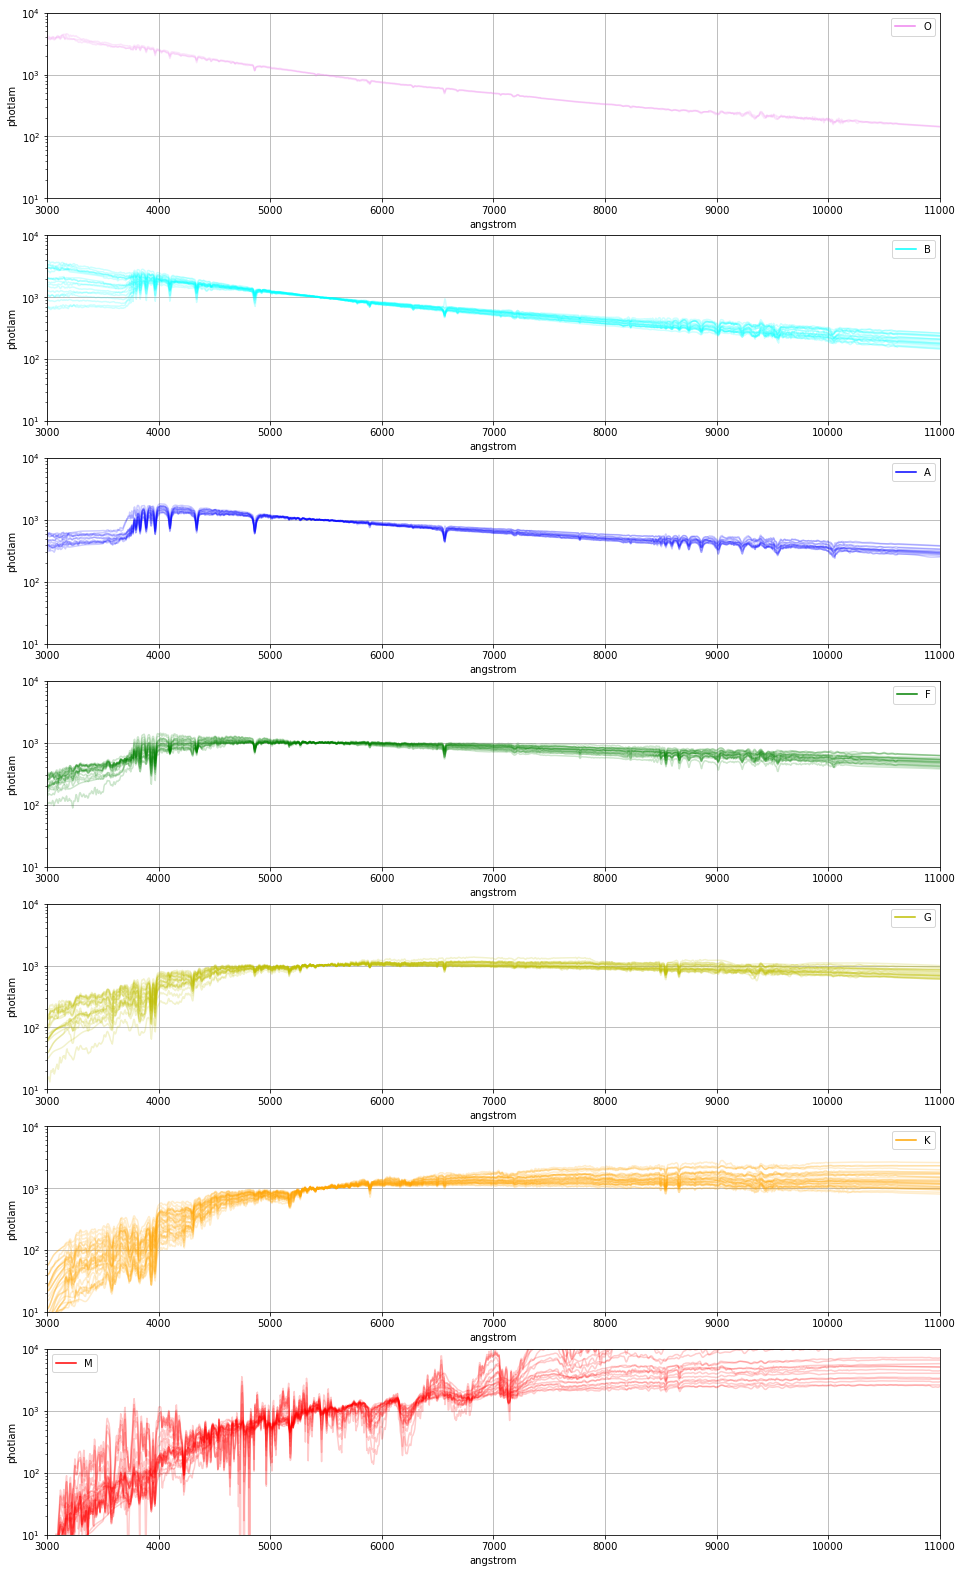

In [14]:
num_rows = len(spectral_types)
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    for spec in spec_by_type[st]:
        axs[row].plot(spec.wave,spec.flux,color=type_colors[st],alpha=0.2)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(spec.waveunits)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    axs[row].set_ylim(10,10000)
    axs[row].set_yscale("log")
            

# Load LSST transmissions file 

In [15]:
datafilename = "data/lsst/old/transmissions-LSST.dat"
df=pd.read_csv(datafilename,names=['wl','Topt','Tccd','U','G','R','I','Z','Y4','atm'],sep='\t')

In [16]:
wl=df['wl'].values
U=df['U'].values/100.
G=df['G'].values/100.
R=df['R'].values/100.
I=df['I'].values/100.
Z=df['Z'].values/100.
Y4=df['Y4'].values/100.

lsst_bp = []
lsst_bp.append(S.ArrayBandpass(wl*10, U , name="u"))
lsst_bp.append(S.ArrayBandpass(wl*10, G , name="g"))
lsst_bp.append(S.ArrayBandpass(wl*10, R , name="r"))
lsst_bp.append(S.ArrayBandpass(wl*10, I , name="i"))
lsst_bp.append(S.ArrayBandpass(wl*10, Z , name="z"))
lsst_bp.append(S.ArrayBandpass(wl*10, Y4 , name="Y"))

In [17]:
filters = ['u','g','r','i','z','Y']
filter_names = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'Y'}
filter_colors = {0:'b',1:'g',2:'r',3:'orange',4:'k',5:'grey'}

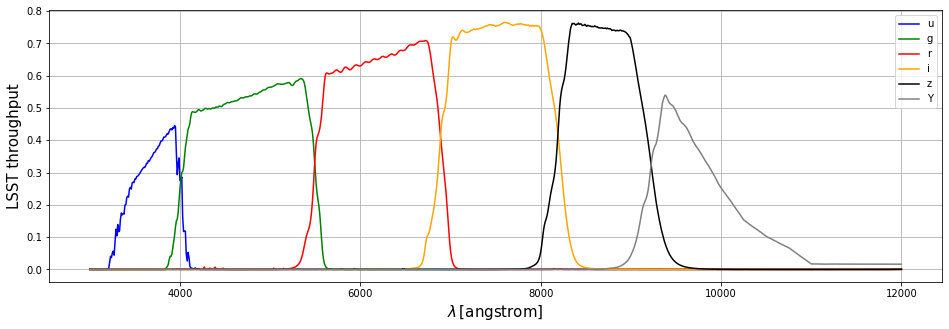

In [18]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

We find a leakage at higher wavelengths for some filters that impacts the colour values of the M type stars 

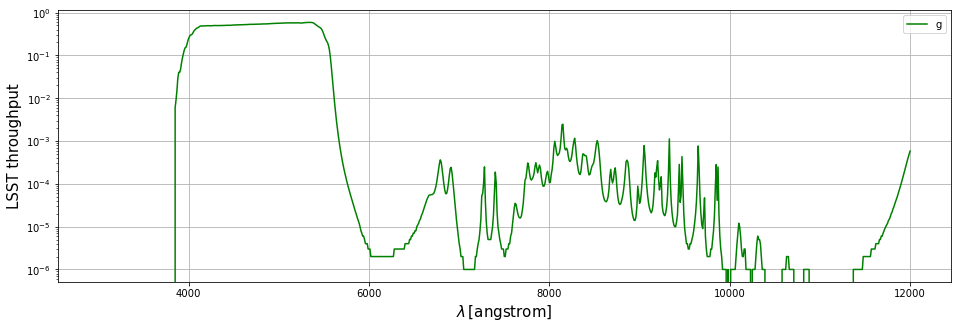

In [19]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
index=1
ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
ax.set_yscale("log")
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

Let's try with a more updated version of the throughputs. We are given only the total passband and the atmosphere that was used to generate them (https://github.com/lsst/throughputs/tree/main/baseline), so in order to have the throughputs we need to divide the passbands by this atmosphere 

In [20]:
total_passband_path = 'data/lsst/'
total_passband_label = 'total_{0}.dat'
atm_lsst_file = 'atmos_std.dat'

In [21]:
atm_lsst = np.loadtxt(total_passband_path+atm_lsst_file)

Now, we write the passbands in pysynphot format: 

In [22]:
wl = atm_lsst[:,0]*10.

lsst_bp = []
for f in filters:
    passband_ = np.loadtxt(total_passband_path+total_passband_label.format(f.lower()))
    assert (atm_lsst.shape==passband_.shape)
    throughput_ = passband_[:,1]/atm_lsst[:,1]
    lsst_bp.append(S.ArrayBandpass(wl, throughput_ , name=f))



/tmp/ipykernel_6248/1969671528.py:7: RuntimeWarning: invalid value encountered in true_divide
  throughput_ = passband_[:,1]/atm_lsst[:,1]


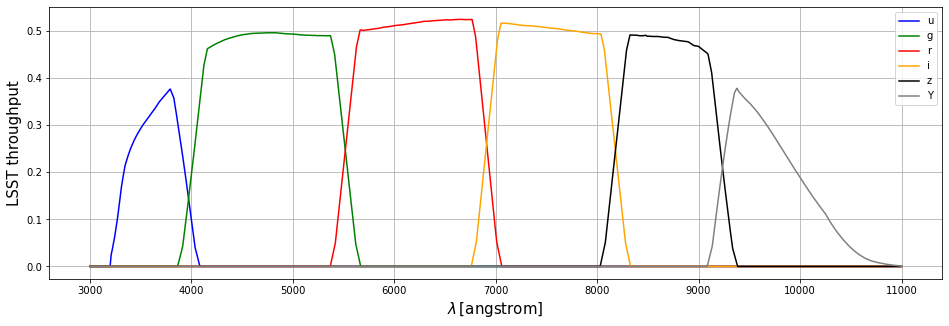

In [193]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp)):
    ax.plot(lsst_bp[index].wave,lsst_bp[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+str(lsst_bp[0].waveunits)+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()
plt.savefig(os.path.join(outdir_plots0,'LSST_throughputs.png'))

In [24]:
for filter in lsst_bp:
    assert (filter.wave==lsst_bp[0].wave).all()

In [25]:
wl_lsst = lsst_bp[0].wave

# Compare with hardware.dat 

# Load simulated transparencies 

Select variable parameter and specify airmass and clouds 

In [26]:
variable_param = 'pwv'
am0 = 1.2
cloud0 = 0.0

Specify which distribution follows the simulated parameter. Options: 
* linear_distribution-discrete: generated following a linear function and with pre-established step (e.g., PWV = 1.0, 2.0, 3.0, ....) 
* linear_distribution-continuous: generated following a linear function and specifying only the value range and number of simulations (e.g., PWV = 1.0, 1.25, 1.5, ....) 
* uniform_distribution: generated following a uniform random distribution (work in progress) 
* specific_distribution: generated following random distributions specific to each parameter (work in progress) 


In [27]:
param_dist = 'linear_distribution-discrete'

In [28]:
outdir_plots = os.path.join('output_plots/',param_dist.replace('-','/'))
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [29]:
if variable_param=='airmass' or variable_param=='cloud':
    t_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
    t_file_ref = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    t_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)
    t_file_ref = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)

t_path = os.path.join('./simulated_transparencies/',param_dist.replace('-','/'))
t_in = os.path.join(t_path,t_file)
t_in_ref = os.path.join(t_path,t_file_ref)
t = fits.open(t_in)
t_ref = fits.open(t_in_ref)

In [30]:
head = t[0].header
data = t[0].data
print(data.shape)
data_ref = t_ref[0].data
print(data_ref.shape)

(10, 956)
(2, 956)


In [31]:
n_atmp = head['ID_RES']
n_sim = head['NTRANSP']
print(n_atmp, n_sim)

5 9


In [32]:
wl_t = data[0][n_atmp:]*10.

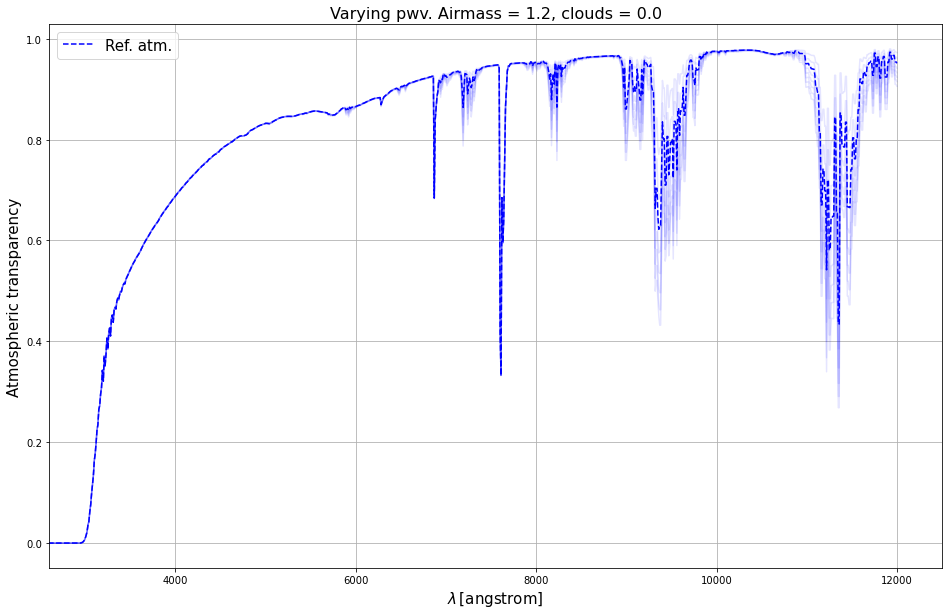

In [160]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for atm_i in range(1,n_sim):
    ax.plot(wl_t,data[atm_i][n_atmp:],color='b',alpha=0.1)
ax.plot(wl_t,data_ref[1][n_atmp:],ls='--',color='b',label='Ref. atm.')
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \,$'+'[angstrom]',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.legend(fontsize=15)
plt.savefig(outdir_plots+'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0))

# Check range of simulated atm values

In [34]:
print(head)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  956                                                  NAXIS2  =                   10                                                  NTRANSP =                    9                                                  ID_AM   =                    4                                                  ID_VAOD =                    1                                                  ID_PWV  =                    0                                                  ID_O3   =                    2                                                  ID_CLD  =                    3                                                  ID_RES  =                    5                                                  END                                     

In [35]:
params_index = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}

In [36]:
var_index = params_index[variable_param]

In [37]:
#data[1:,1]
data[1:,var_index]

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

(array([0., 0., 0., 0., 0., 0., 9., 0., 0., 0., 0., 0.]),
 array([-0.5       , -0.41666667, -0.33333333, -0.25      , -0.16666667,
        -0.08333333,  0.        ,  0.08333333,  0.16666667,  0.25      ,
         0.33333333,  0.41666667,  0.5       ]),
 <a list of 12 Patch objects>)

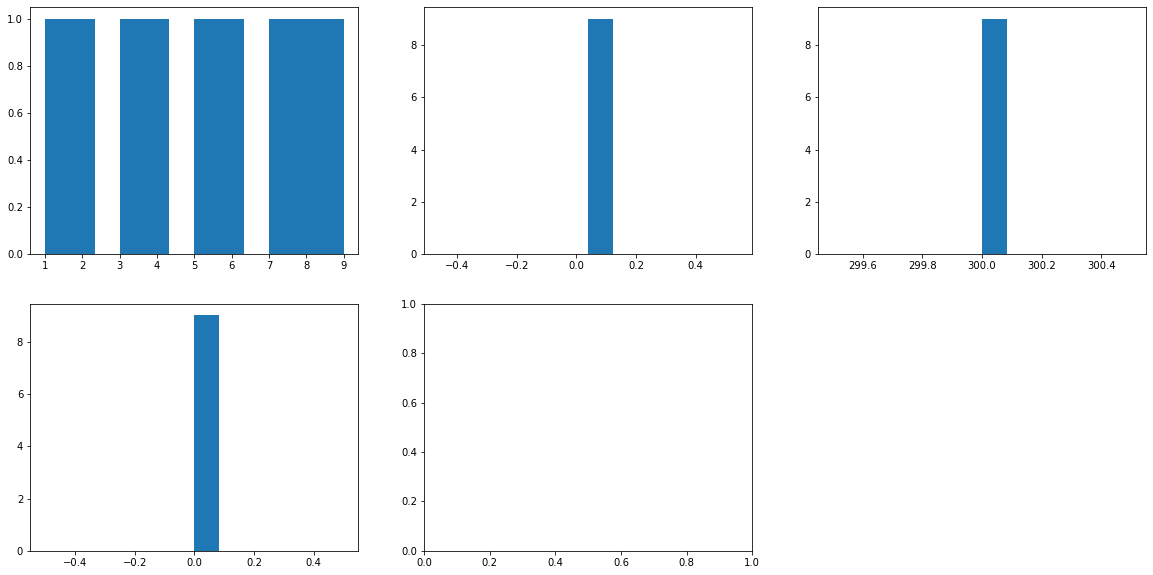

In [38]:
fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(231)
ax2=fig.add_subplot(232)
ax3=fig.add_subplot(233)
ax4=fig.add_subplot(234)
ax5=fig.add_subplot(235)

ax1.hist(data[1:,0],bins=12)
ax2.hist(data[1:,1],bins=12)
ax3.hist(data[1:,2],bins=12)
ax4.hist(data[1:,3],bins=12)

# Select data for variable parameter of these simulations 

In [39]:
atm_vals = data[1:,var_index]

In [40]:
np.save('output_files/atm_vals_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),atm_vals)

# Convert simulated transparencies into pysynphot format 

In [41]:
atm_transp = []
for i in range(1,n_sim+1):
    finterp_i = interp1d(wl_t,data[i][n_atmp:],bounds_error=False,fill_value=0.)
    atm_interp_i = finterp_i(wl_lsst)
    #atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
    atm_i = S.ArrayBandpass(wl_lsst,atm_interp_i, name='Atm. transp. {0}'.format(i))
    atm_transp.append(atm_i)

In [42]:
finterp_ref = interp1d(wl_t,data_ref[1][n_atmp:],bounds_error=False,fill_value=0.)
atm_interp_ref = finterp_ref(wl_lsst)
#atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
atm_transp_ref = S.ArrayBandpass(wl_lsst,atm_interp_ref, name='Atm. transp. {0}'.format(i))

# Compute total bandpass (atmosphere(s) x LSST throughput) 

In [43]:
total_passband = {}
#for bpname in filters:
#    total_passband[bpname] = []

for index,bp in enumerate(lsst_bp):
    total_passband[filters[index]] = []
    for i in range(n_sim):
        total_pass = bp*atm_transp[i]
        total_passband[bp.name].append(total_pass)

In [44]:
total_passband_ref = {}
for index,bp in enumerate(lsst_bp):
    total_pass = bp*atm_transp_ref
    total_passband_ref[bp.name] = total_pass

In [45]:
print(len(total_passband['u']))
print(total_passband['u'][0])

9
(u * Atm. transp. 1)


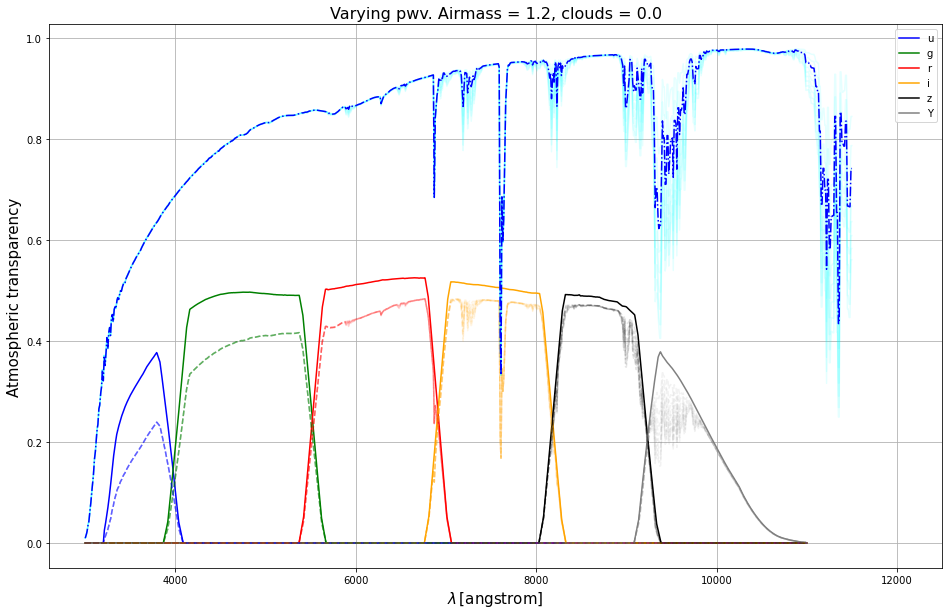

In [46]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

for isim in range(n_sim):
    ax.plot(atm_transp[isim].wave,atm_transp[isim].throughput,alpha=0.1,color='cyan')
    for index,bpname in enumerate(filters):
        ax.plot(total_passband[bpname][isim].wave,total_passband[bpname][isim].throughput,ls='--',color=filter_colors[index],alpha=0.1)
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='-.',color='b')        
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.legend()
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(outdir_plots+'total_passbands_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0))

Plot the atmospheric transparencies corresponding to the minimum and maximum atmospheric parameter that we are varying: 

In [47]:
min_val_ = np.min(atm_vals)
max_val_ = np.max(atm_vals)
print(min_val_,max_val_)

1.0 9.0


In [48]:
min_ind_ = np.where(atm_vals==min_val_)[0][0]
max_ind_ = np.where(atm_vals==max_val_)[0][0]

In [49]:
min_transp = data[1+min_ind_,n_atmp:]
max_transp = data[1+max_ind_,n_atmp:]

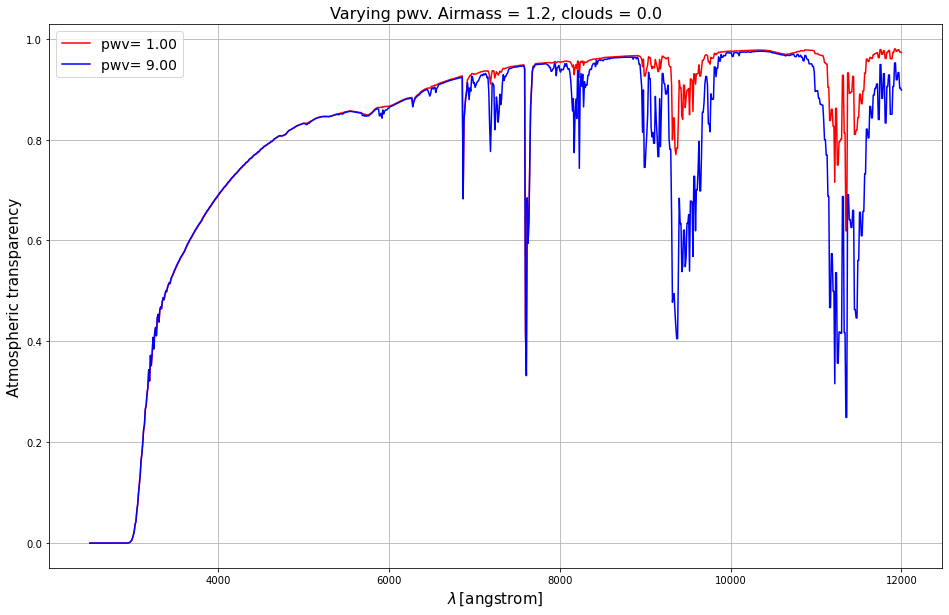

In [50]:
fig=plt.figure(figsize=(16,10))
plt.plot(wl_t,min_transp,color='r',label=variable_param+'= {0:.2f}'.format(min_val_))
plt.plot(wl_t,max_transp,color='b',label=variable_param+'= {0:.2f}'.format(max_val_))
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.grid()
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(outdir_plots+'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}_min_max_values.png'.format(variable_param,am0,cloud0))

# Calculate fluxes through total passbands 

Let's start with one spectrum of a type A star as example 

In [51]:
# Example with one spectrum 
test_type = 'A'
test_spec = 0
example_spec = spec_by_type[test_type][test_spec]

In [52]:
# It seems this galaxy is a small enough place to end up choosing again, just by coincidence, Vega as example star 
vega = S.Vega
vega.convert('photlam')

photlam


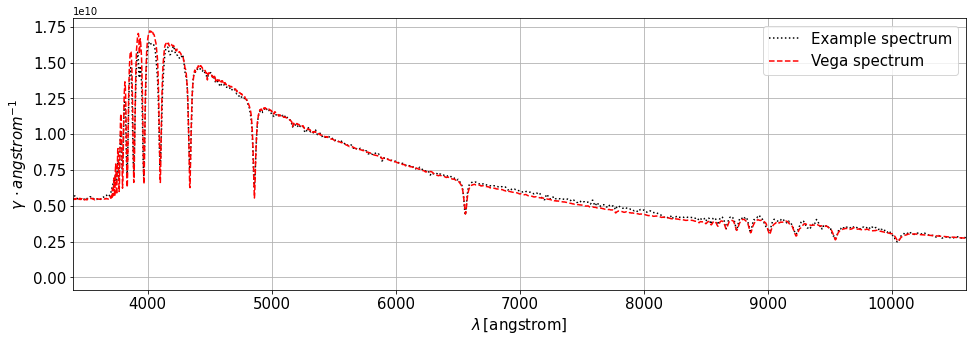

In [53]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0,label='Example spectrum')
plt.plot(vega.wave,vega.flux*Seff*exptime,ls='--',color='r',alpha=1.0,label='Vega spectrum')
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(example_spec.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
print(spec.fluxunits)

Let's make the example spectrum pass through the atmosphere and through the total passband (atm. x throughput) 

In [54]:
obsatm_dict = {}
for isim in range(n_sim):
    obsatm_dict[isim] = []
    obsatm = S.Observation(example_spec,atm_transp[isim],force='taper')
    obsatm_dict[isim] = obsatm

obstotal_dict = {}
for filter in filters:
    obstotal_dict[filter] = []

#for filter in lsst_bp:
for filter in filters:
    #print(filter.name.upper())
    for i in range(n_sim):
        #total_pass = filter*atm_transp[i]
        #obs = S.Observation(spec,total_pass,force='taper')
        obstotal = S.Observation(example_spec,total_passband[filter][i],force='taper')
        obstotal_dict[filter].append(obstotal)

(Atm. transp. 1) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 2) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 3) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 4) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 5) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 6) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 7) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 8) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Atm. transp. 9) does not have a defined

u
g
r
i
z
Y
photlam


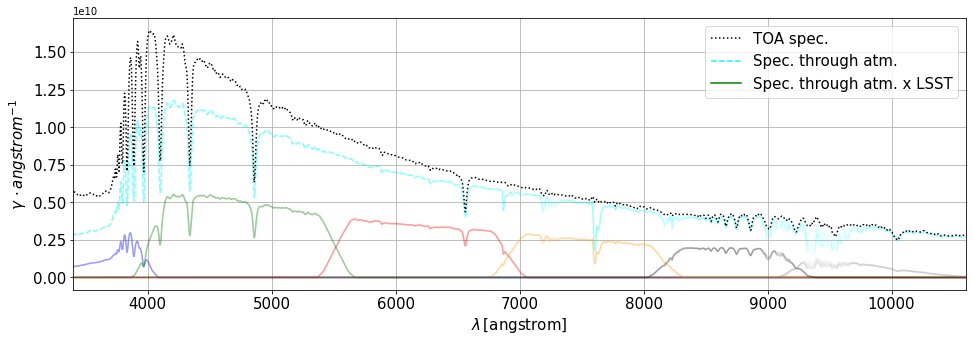

In [55]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    obsatm = obsatm_dict[isim]
    ax.plot(obsatm.binwave,obsatm.binflux*Seff*exptime,ls='--',color='cyan',alpha=0.07)

for index,filter in enumerate(obstotal_dict.keys()):
    print(filter)
    for obs in obstotal_dict[filter]:
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls=':',color='k',alpha=1.0)
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.plot([],[],ls=':',color='k',label='TOA spec.')
plt.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
plt.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
print(spec.fluxunits)

This was an example of how the spectrum looks like when passing only through the atmosphere and through the total passbands. For our calibration purposes, what we actually want is to have the spectra passing through either only the troughput (as if the telescope was on space) and through the total passband (ground-based telescope). Now let's pass all spectra through the throughput and through the atmosphere 

In [56]:
# Spectra through atm x throughput 
obs_dict = {}
#for sed_ in list(sed_dict.keys()):
for st in spectral_types:
    print(st)
    obs_dict_ = {}
    for si,spec in enumerate(spec_by_type[st]):
        filter_dict_ = {}
        for filter in filters:
            filter_dict_[filter] = []
            for i in range(n_sim):
                obs_spec = S.Observation(spec,total_passband[filter][i],force='taper')
                filter_dict_[filter].append(obs_spec)
        obs_dict_[si] = filter_dict_ 
    obs_dict[st] = obs_dict_


O
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used

((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

In [57]:
print(len(sed_dict.keys()))
print(len(obs_dict.keys()))
print(len(obs_dict[test_type].keys()))
#print(len(obs_dict[example_spec].keys()))
print(len(obs_dict[test_type][test_spec].keys()))
print(len(obs_dict[test_type][test_spec]['u']))
print(n_sim)

131
7
13
6
9
9


In [58]:
# Spectra only through throughput (as if telescope was in space) 
obs_dict_t = {}
for st in spectral_types:
    print(st)
    obs_dict_t_ = {}
    for si,spec in enumerate(spec_by_type[test_type]):
        filter_dict_ = {}
        for filter in lsst_bp:
            obs_spec_t = S.Observation(spec,filter,force='taper')
            filter_dict_[filter.name] = obs_spec_t
        obs_dict_t_[si] = filter_dict_ 
    obs_dict_t[st] = obs_dict_t_
    

O
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset 

In [59]:
print(len(sed_dict.keys()))
print(len(obs_dict_t.keys()))
print(len(obs_dict_t[test_type].keys()))
print(len(obs_dict_t[test_type][test_spec].keys()))

131
7
13
6


In [60]:
obs_dict_t[test_type][0]['u']

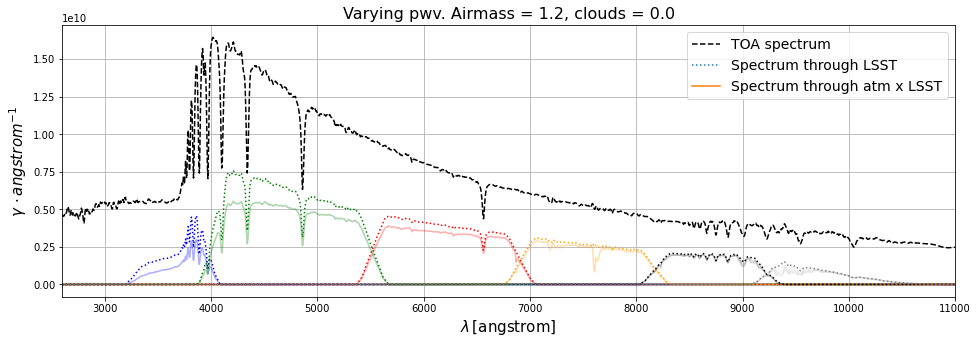

In [61]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
#sed_dict[example_spec].convert('photlam')
spec_by_type[test_type][test_spec].convert('photlam')
plt.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(obs_dict_t[test_type][test_spec][filter].wave,obs_dict_t[test_type][test_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = obs_dict[test_type][test_spec][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)

plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)
plt.savefig(outdir_plots+'example_spectrum_toa_throughput_total_passband_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0))

# Calculate magnitudes with my own function 

Physical constants 

In [62]:
c_light = S.units.C #speed of light [Angstrom /s] 
print(c_light)
h_planck = S.units.H #Planck's constant [erg*s] 
print(h_planck)

2.99792458e+18
6.6262e-27


In [63]:
# Reference flux value for an AB source in erg / s / cm2 / Hz 
f_ref = 3.63*10**(-20)

In [64]:
# Pivot wavelength [cm] 
wl_piv = 5.4929*10**(-5)

In [65]:
C = f_ref/(h_planck*wl_piv*10**8.)
print(C)

997.3334660532323


Definition of functions 

In [66]:
# The SED of an AB source (that is, constant flux in frequency units) expressed in photons / s / cm^2 / Angstrom 
def ABnphot(wl):
    #return 997.2*5500./wl
    return C*wl_piv*10**8./wl

In [67]:
def myAB(spec,passband,filter):
    f_units = str(spec.fluxunits)
    if f_units!='flam':
        print('ATTENTION: converting flux units to flam')
        spec.convert('flam')
        
    observation = S.Observation(spec,passband,force='taper')
    nan_mask = np.isnan(observation.flux)
    
    num = np.trapz(observation.flux[~nan_mask]/observation.wave[~nan_mask],x=observation.wave[~nan_mask])
    #obmag = -2.5*np.log10(num)
    
    spec.convert('photlam')
    
    #print(num)
    
    #flatsp = S.FlatSpectrum(f_ref,fluxunits='fnu')
    #flatsp_vals = np.ones(len(spec.wave))*f_ref
    #flatsp = S.ArraySpectrum(spec.wave,flatsp_vals)
    
    flatsp_nphot = ABnphot(spec.wave)
    flatsp_ = S.ArraySpectrum(spec.wave, flatsp_nphot, name='Flat AB spectrum')
    
    flatsp_.convert('flam')
    ab_obs = S.Observation(flatsp_,filter,force='taper')
    den = np.trapz(ab_obs.flux[~nan_mask]/ab_obs.wave[~nan_mask],x=ab_obs.wave[~nan_mask])
    
    #print(den)
    #print(num/den)
    #print(obmag)
    mab = -2.5*np.log10(num/den)
    print(mab)
    return mab

In [68]:
# This function gives the flux of an AB source in photons / s / cm^2 / Angstrom 
flatsp_nphot = ABnphot(example_spec.wave)

In [69]:
#Let's write this in pysynphot format (note that the result will be in photlam units, then we use ABnphot as input)
flatsp = S.ArraySpectrum(example_spec.wave, flatsp_nphot, name='Flat AB spectrum')

In [70]:
flatsp.fluxunits

photlam


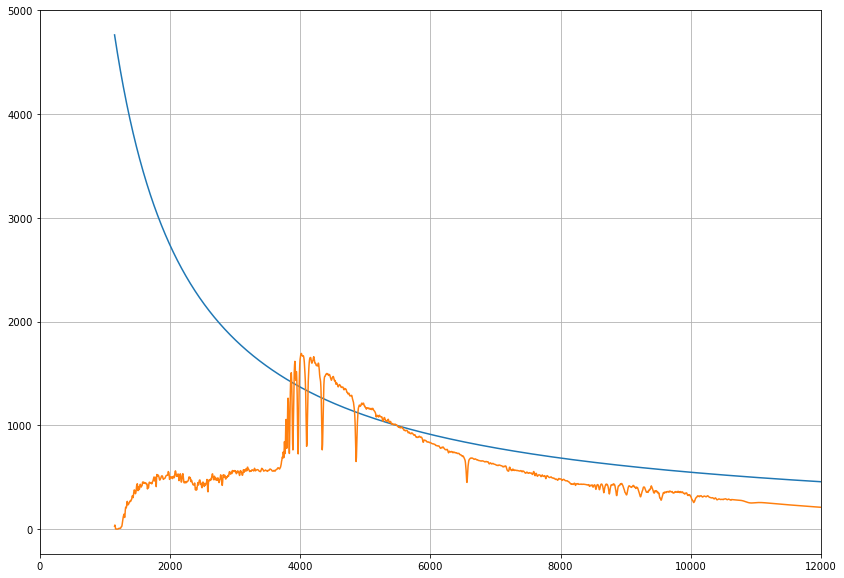

In [71]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
example_spec.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(example_spec.wave,example_spec.flux)
plt.xlim(0.,12000.)
plt.grid()

In [72]:
flatsp0 = S.FlatSpectrum(f_ref,fluxunits='fnu')
flatsp0.fluxunits

Here we verify that creating a pysynphot AB flat spectrum and transforming it to photlam gives the same as directly creating the same spectrum in photlam units with ABnphot 

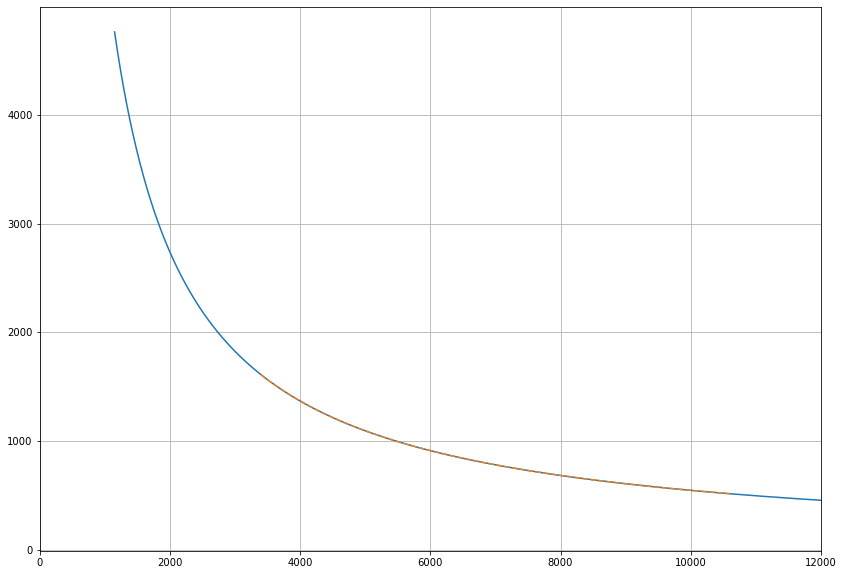

In [73]:
flatsp0.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(flatsp0.wave,flatsp0.flux,ls='--')
plt.xlim(0.,12000.)
plt.grid()

To further check it, let's transform it to flam and compare with the analytical expression: 

$$F_{\lambda} = F_{\nu} \frac{c}{\lambda^2}$$

In [74]:
flambda = f_ref*c_light/flatsp.wave**2.

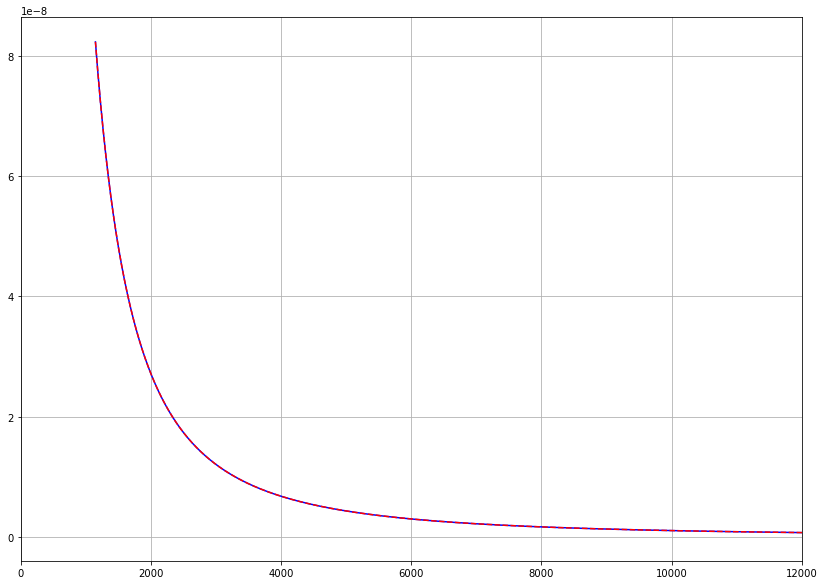

In [75]:
flatsp.convert('flam')
flatsp.waveunits
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux,color='b')
plt.plot(flatsp.wave,flambda,color='r',ls='--')
plt.xlim(0.,12000.)
plt.grid()
flatsp.convert('photlam')

Now we check that the AB magnitudes are zero for the flat AB spectrum (they have to be through any filter, by definition) 

In [76]:
for filter in lsst_bp:
    myAB(flatsp,filter,filter)

ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of 

We check the same for the total passband. Note that, given the definition of AB magnitudes that we have implemented, the denominator only considers the throughput of the telescope, even when the spectra pass through the total passband, since the "reference" we want to compare to is when there is no effect of the atmosphere, but in any case the light passes through the telescope, so we consider the telescope's throughput to be the reference (i.e. as if it had a transmission = 1) with respect to which the flux is attenuated. Therefore, the following AB magnitudes of a flat AB spectrum should be different from (greater than) zero  

In [77]:
for fi,filter in enumerate(filters):
    myAB(flatsp,total_passband[filter][0],lsst_bp[fi])

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.605048695874859
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26122006546925514
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1405209361914125
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The 

Now, let's see the AB magnitudes of the example spectrum with myAB function. To better understand it, we can compare the AB spectrum and the example spectrum (Vega) flux amplitudes in each range of wavelengths (see plot below) 

photlam


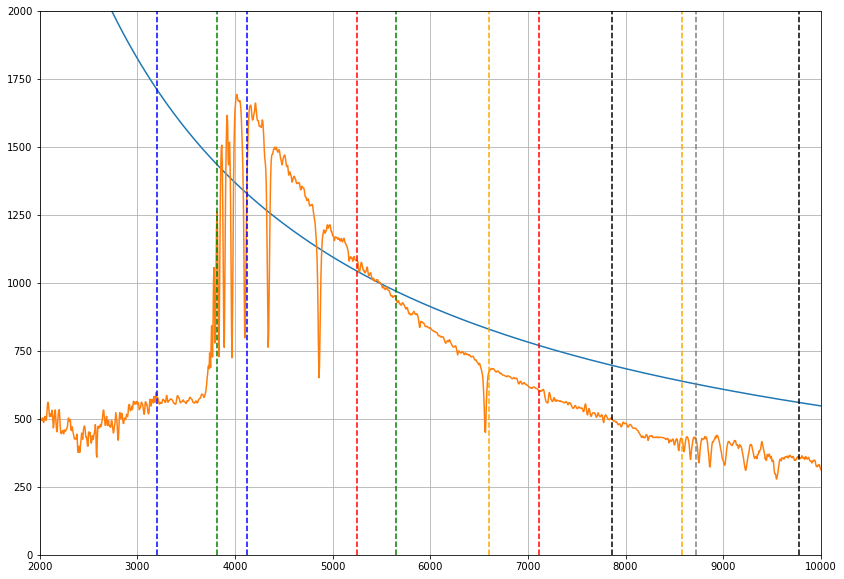

In [78]:
print(flatsp.fluxunits)
flatsp.convert('photlam')
example_spec.convert('photlam')
plt.figure(figsize=(14,10))
plt.plot(flatsp.wave,flatsp.flux)
plt.plot(example_spec.wave,example_spec.flux)

# Approximate integration limits of each total passband. Note that there is some overlap 
plt.axvline(x=3200,ls='--',color=filter_colors[0])
plt.axvline(x=4120,ls='--',color=filter_colors[0])

plt.axvline(x=3820,ls='--',color=filter_colors[1])
plt.axvline(x=5650,ls='--',color=filter_colors[1])

plt.axvline(x=5250,ls='--',color=filter_colors[2])
plt.axvline(x=7110,ls='--',color=filter_colors[2])

plt.axvline(x=6600,ls='--',color=filter_colors[3])
plt.axvline(x=8580,ls='--',color=filter_colors[3])

plt.axvline(x=7860,ls='--',color=filter_colors[4])
plt.axvline(x=9780,ls='--',color=filter_colors[4])

plt.axvline(x=8720,ls='--',color=filter_colors[5])
plt.axvline(x=12000,ls='--',color=filter_colors[5])

plt.xlim(2000.,10000.)
plt.ylim(0.,2000.)
plt.grid()

In [79]:
for filter in lsst_bp:
    myAB(example_spec,filter,filter)

ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.765021086705792
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09951151871534347
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12690586603750892
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined 

In [80]:
for fi,filter in enumerate(filters):
    myAB(example_spec,total_passband[filter][0],lsst_bp[fi])

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3267931783528546
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.16359894286507842
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2693968505200761
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The

# Calculate magnitudes and colours

We compute the magnitudes for the spectra of each spectral type for each atmosphere 

In [81]:
# Magnitudes of spectra passing through atm x throughput 
mag_dict = {}
mag_dict_ref = {}
for st in spectral_types:
    print(st)
    
    mag_dict_st = {}
    mag_dict_ref_st = {}
    for si,obs_spec_ in enumerate(spec_by_type[st]):
        mag_dict_ = {}
        mag_dict_ref_ = {}
        for fi,filter in enumerate(filters):
            mag_dict_[filter] = []
            for i in range(n_sim):
                #mag_dict_[filter].append(obs_spec_[filter][i].effstim("abmag"))
                mag_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi])
                mag_dict_[filter].append(mag_ab_)
                
            #mag_dict[sed_] = mag_dict_
                    
            mag_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi])
            mag_dict_ref_[filter] = mag_ab_
        mag_dict_st[si] = mag_dict_
        mag_dict_ref_st[si] = mag_dict_ref_
    mag_dict[st] = mag_dict_st
    mag_dict_ref[st] = mag_dict_ref_st
        

O
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.17666368088945927
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.17667498624140063
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1766882177887075
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat tabl

0.3862369660039273
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38288861336823715
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7191790796677188
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7220873847094013
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08848132938904829
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08867386967715869
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08935611763063725
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09131

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7250870966889501
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7277107956603917
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7304236345952685
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.733386282968

-0.1001598871603557
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10018015356283128
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10037312527720478
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1010569283815374
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset i

((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7202942392020422
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7230011404547654
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7256290036289513
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.027648043756702642
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.02765929456658284
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.02767246351139348
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0276

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6839602910101157
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6868408011496638
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6896218964943293
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.692314397905

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1797325335620399
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.15741715422556843
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1574059202976128
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.15739277032

((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3466942693912288
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.634444919138665
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6373174149677209
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inste

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.200172133071765
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.073967878582468
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.43160348740874643
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4315924210605

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3426849407199222
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3430450921940741
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.33967644986589635
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.55683999057

1.0750828396573402
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0944159037495944
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1111198926846804
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.985924232910526
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the w

((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3126315271364733
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31328403070593025
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3145960894352131
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used ins

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9077877635439623
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9308827729107645
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9520396205526169
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.971848474699

0.2790850803721739
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.279399237622454
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2797143146269091
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2801333206327099
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the w

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7353965707943299
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7646881762959007
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7900599402816966
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.812711408344

0.2668387710246194
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2671516081944746
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2674645415352662
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26777840648798046
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the

0.5655017926170689
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6932274246432111
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7292871905305083
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7586387758931987
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.04366145609535117
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.042925338694903135
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3524786942910415
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3527936

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8535841455971049
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8593176876792247
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8634259626183027
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.833341034007

0.08262080313737191
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08246305149876841
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08197464502982116
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08196331959444678
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in 

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6166540458085409
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6216489383917694
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6267008516286278
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.632519736882

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.006867800105149342
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.006855876714426568
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0068909219342322085
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.831667652370428
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8370206177512136
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8420330554956248
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8469141122987

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.030239852335371027
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03025476588015037
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.030269185086408967
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0302829

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.571795455000891
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7291726996904182
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7355200187209006
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7413547034566

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6620179107144688
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6649193443489686
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0542092192081164
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.054224385214

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5247128101843294
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5285312655167893
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5309375916753061
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.513837320210

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1081063138537957
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1062621775358947
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1061532115044619
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.108963547177

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4849610919810685
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4887899723989274
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.49120658041465765
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.47404024484

0.24500956539157565
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2448181158941083
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24413974295771648
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.24219103863190533
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in t

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6166984103562831
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6192982648995708
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6219878912472268
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.624927935767

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5431345617475004
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5431189295982887
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5430991066542461
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.542910648827

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5367641595552917
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5396481896760355
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5424324393726867
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.545127775271

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9600312570425908
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08173075463205894
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08171946911249464
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0817062601

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6072058703292522
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6100709342136383
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6128377980798035
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.615517124123

0.1883183036491716
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.18812678823786289
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.18744818462404983
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.18549881734799184
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in t

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5368006897539012
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7787508913115377
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7850826024950686
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.790898480004

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3974030923074639
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.39728911126625066
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4002284065081588
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08046733220

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5346565472985545
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5384958295972299
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5409229706197162
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.523688086547

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5232135502106958
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5225452741852239
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5206254502572799
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.520512001382

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4289649615557142
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4315797619000921
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4342835375149995
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.437237054697

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7119133628135165
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7119005428279059
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7118850588350424
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.711865426477

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.41231055190103094
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4149472003505543
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4175074972501257
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.42015889251

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3267931783528546
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3267825300443787
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3267700598849657
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.326754996797

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4143656046943027
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.41701961538925186
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.41959634727732753
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4222633647

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3844039630315297
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3843889758546961
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.384369974971626
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3841897712896

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38164563693639675
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3844031732625794
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38707233369140975
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3896630560

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6384679813058267
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4357221626938999
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4357115412310886
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.435699102942

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.33676509039683566
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3395252647911061
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.34219680115755347
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3447896475

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6079061816308098
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5245672439763533
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5245566512896522
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.524544247766

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2881241026152557
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.29086219054953555
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.29351294289313573
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2960861577

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4570397156441313
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.586605938330967
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.586595257669945
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.58658275265660

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.21390704398525362
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.21666731419138624
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.21933892922992274
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.221931838

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.35077056757455144
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2701139118797427
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2701032875757112
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.27009084616

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26980768168192626
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2664366903972968
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4223861321644767
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.42525673095

1.4560627976202078
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4560503733321917
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4560353633939567
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.4560163344344539
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the 

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3337620054875743
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3365589422204102
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3392654209227242
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.341891619181

1.330613034381235
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3306005359694666
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3305854381795046
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.3305662965340637
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the w

0.2559756322009023
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4110000505836807
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.41387554202498045
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.41665171258195133
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in th

0.6626294048596492
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5239727433556582
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.523962196719072
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5239498457223464
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the w

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3518531176878874
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.35453657817271
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.35714157403531427
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3598357704727

1.5703366294382142
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.570326006353996
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.5703135691958048
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.570298542588242
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wa

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.27210911252327513
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2748276482380093
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.27746587202023365
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2801916763

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6399552595928026
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.639944628597603
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6399321820032722
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6399171444920

((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.21568275821052638
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.21835686196668647
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2209520845763408
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used in

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0469462838125432
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0469338534388024
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0469188399345541
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.046899806068

0.24899091537388818
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.36138879834094745
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3642450314482992
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.36700246159473343
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in t

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7188637245096459
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5946593103585323
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1629411215424166
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.162930444035

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.21038530691603308
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3072693345959824
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.31014239068750454
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3129161153

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.684890347471143
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5606258146326386
F
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6458126201651193
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.64580185037

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12900099269496518
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08971728955793394
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.09252753938207942
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.095240718

0.368192263380998
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38430550769072924
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2633068800912243
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.685351349371178
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the w

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1055633254281734
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.10689723653349263
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.10726150627519561
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1038422095

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.15371244655091781
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1741695776160916
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.19332983379457327
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2122010180

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07858148515893834
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07900996243516664
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07967673719730743
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.081016394

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07359868888399403
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.09902334455396558
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12171884121079368
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.142503312

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07173413141422247
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07205583153184678
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07248422810115754
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.073150981

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07900630037654179
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.10736861574704144
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.13196085155233192
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.153928157

0.05941986647274371
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.059742954568817
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.060066032492908095
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.06038994942573866
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in t

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.06124454431552967
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.025616438175058286
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.003394735621944426
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02852

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03909997953686199
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03942265609341386
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.039745321251904574
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04006882

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.15646728348649827
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12218874352840547
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09422840707093028
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.06998

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5216755870272471
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5220635876687483
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03188906734004967
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03221291034

-0.05485719487680334
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.034594907101733796
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.015614952670039447
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0030864782638495855
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined bin

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.043597230129981256
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04402837749802471
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04469860040494757
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.04604441

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.037260417025457473
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.05773791943537317
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.07691682156419273
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.09580464

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.019794418241375504
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02011927433325475
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02044494889044755
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02087815

-0.1454919193133194
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.11679933518658259
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09193504081690745
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.06973052609568944
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset 

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11379618356908282
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11416294627738913
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.11073010319352047
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.059144278

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7148417058300929
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7141880226880168
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.712309964095329
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7121989911521

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.009532140219508125
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.00688165198829284
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.003979953939942434
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.000

((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.964326639745122
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.964140753089374
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.9634822794512048
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instea

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.13993961718193398
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.13342695829322457
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12745091226196328
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12190

((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.6789917588307142
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3393982366536152
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3394171414660804
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12016393879675762
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12668642658057275
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.13266788815057545
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.138220157

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.7473804920914264
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4436467828035696
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.44366682416864617
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.44368651706

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.014992179252968493
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02096134759831315
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.026505465558304613
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0316913

1.7887443697586747
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.445280383932809
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4453006234472706
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.445320515117538
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wa

-0.04159591774021538
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.035514803539824905
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.029869966328260607
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0245921983894351
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binse

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2626162052035521
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26263376241509867
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2626507711826443
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.26266680969

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.29417542721563583
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.300639371531634
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3065756507433949
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.312091340961

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3881349371569725
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38813332968228914
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.38861075638423775
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1204630922

((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.14335328936775343
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.14921609400138658
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.15344357070059944
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2942899142993622
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.294285492631521
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.2948170469133803
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1707340859645

0.3046420295278206
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.32531128128074743
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.3446713927089667
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.36373223819321504
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in th

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0864967466704096
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08925224680477939
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.09191941040478169
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0945081219

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5508352191821381
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5508573717841394
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.550879226584945
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5509006978713

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.01644926329610208
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.010545789619817397
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.006280067126871566
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.037

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.025332853047360295
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.025655776446769914
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.025979528388550194
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.026410

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12901636178336948
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10401037046130206
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08167888344586635
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.06121

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.020961761217677188
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.02128582366053046
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.021609420428632002
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0219329

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.18858666229616994
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2197931692710563
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.20598484973398276
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.170937

0.003055163097788012
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0033776631140050827
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0037001362689557077
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0040234357762927815
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined bin

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.11759760466531023
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1012341296598636
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.22422360285522916
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.1185843

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0012750366094320981
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0006026058716898761
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0007473927816792822
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0

-0.13700529302488818
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.11827815766680222
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10215206294204741
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2232873088769729
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset 

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.22171892722483588
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2189756027470119
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.21632085801079085
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.213744

2.0746410094502736
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.0744546806091755
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.0737946402258296
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.071898328404808
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the w

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.16181442535088075
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1787829330210478
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2627968918430346
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2563232

2.30773573087745
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.3058426993517047
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.3057308417075166
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.308615701865935
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wav

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.20967778072308613
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.20678252012371096
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.20299879802124013
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.20062

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.437438595067536
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.4367761600883773
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.434872999500802
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.43476054399254

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.27801336563301404
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2742368221649104
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.27187392480659245
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.288707

2.0993718423244374
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.098714711215151
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.096826749473933
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.096715192257022
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wav

-0.12356996891360555
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12115912848283025
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1383111478012432
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2048956423783453
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset i

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.274666502598866
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.2727657434767825
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.272653428248487
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.27555006114696

-0.27585764273648034
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.26933873756272053
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.26336068629477427
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2578130426931412
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset 

0.6433128076067329
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6433094660529655
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6432336158989111
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6429682248148845
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the 

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.326716611269522
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3214944389103614
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.316424970641484
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3113060369

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6877604988393791
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6877832452135899
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6877818954440124
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.687711735656

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.44254821360474506
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4374070397988245
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4322214541390901
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4262791

0.59620497234373
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5959118906995821
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5959176601820755
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5962548481443313
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wa

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2775686154554243
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.27169544540574475
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.267460992037413
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.29854855

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7238546897781394
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7236263912781425
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7236378326162175
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.723867577065

((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4354316174173764
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.42957932017346245
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4253647985040709
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used 

((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6929984445224718
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6930075054938556
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6932835195024691
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.43914824271995656
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.43321279514219274
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4289199036120206
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.460424

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7265022339268172
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.72626933000987
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7262801691801412
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.72651849445093

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4585319146271434
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.45347317645021873
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4476488166255655
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4434587

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7656529904889148
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7655959704386682
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.765381776296862
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7653943692177

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5019692725493107
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.49771730434328315
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5289271926687336
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5569805

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.722525566773896
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08740207315851517
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08707419431134411
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.08674682

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5115273647551798
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4834481296995697
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.45913045248406636
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4374274

-0.07598770353507303
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07565922188656203
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07522235247908464
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.07454477175133614
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.29114289438616536
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2727099846247794
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.25451722074905825
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.238892

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03788827602583812
ATTENTION: converting flux units to flam
((r * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.037562801087080884
ATTENTION: converting flux units to flam
((r * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03712960681137656
ATTENTION: converting flux units to flam
((r * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0364

-0.010861303781453937
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.13288595569112943
ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.8267698444408325
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.826759102328002
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in 

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.24180608024464784
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23890646587036457
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23511865610539928
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.23274

3.17615221937995
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.176132968157993
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.1759506555564787
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.1753049563447275
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wav

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.31625186168750213
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3136545652288581
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3108044857542288
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3070644

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.91958779405066
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9196153764528465
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9196428041069713
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.91966987850029

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5645732922167089
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5593030187012444
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5541966935106624
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.54905010

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6626174768631736
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6626402029494983
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6626623051242774
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.662659015507

-0.4190482632966984
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.41309878756876034
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4087910557413726
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.44036551963453796
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset i

0.698140779418319
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6980708366518682
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.697821850619788
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6978312026943502
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wa

-0.4047725289333554
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.43651645503970027
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4690964323525456
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.43444775263964686
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset i

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7560410157430758
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.13786400181477348
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1375390012794488
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.13721448

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5617943476184719
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5838239831077982
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5485700010250307
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.51986495

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.18856142911465607
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1920558397373523
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5613255330527077
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5584806

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.268885814689932
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.268699936850286
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.268041542235021
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.266149880841988

-0.6612389025800579
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6586100356996518
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.655729907798356
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6519605931836042
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in t

3.6641218364731145
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.663937277678021
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.6632835628503377
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.6614052933999224
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the w

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7662223192112727
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7633242175959282
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7595377909444777
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.75716769

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.7841105291323323
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.78409116245638
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.783907797193604
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.783258358738434

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9381664845338994
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9358208829567389
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9525559683065319
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.26577104

0.7691122566779508
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7691372447155919
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.769162027327248
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7691865543991822
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the w

-0.59744585929934
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5908804610416198
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5848622563454063
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5792794594575776
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in th

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7963344217785716
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7963591416265691
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7963833528943975
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.796386560777

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.687498716362817
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6593404559185712
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6349577289115262
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.613196632

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5995254845907936
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.596900602917229
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5943544161013843
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.591719071

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7646373807300845
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7646410054288799
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7645854317606797
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.764375092142

-0.48698439565537066
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4684669756463747
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.45019848790077366
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.43450621333512307
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset 

((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3912060608805113
ATTENTION: converting flux units to flam
((i * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.38742463866324994
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.38505731111548147
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7933006807345488
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7930988523730056
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.7931126133616279
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.793298450484

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5052642341154079
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.48567864377256
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4673273888667431
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4492134792

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4936933940092128
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4909795538539975
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4883538565935072
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.48580642

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.1561431933411055
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8078101231422846
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8078358944523427
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.807861479250

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6047487473448695
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5704977893708365
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5425885391627021
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.51840935

-0.5148087010704343
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5120231679874787
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5093350591893281
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5067338714304973
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8651641982125238
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8651904793480594
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8652163405762956
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.865224644867

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7455904432041875
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7215364349474565
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7000656529711247
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.68039862

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.49783665578865777
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.49529139437615766
ATTENTION: converting flux units to flam
((i * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.49265648626209496
ATTENTION: converting flux units to flam
((i * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.48977

((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.912708903141924
ATTENTION: converting flux units to flam
((g * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9126761430892725
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9125281510611409
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inste

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6802424459027029
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6616760568371499
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.643366202487313
ATTENTION: converting flux units to flam
((Y * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.627638153

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5937785697171247
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5914319812338099
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6081807926387793
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.81415015

0.891757288106187
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8917843449880104
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8918112496567859
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8918379718889241
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the w

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8721802812909232
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8372925928039165
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8089359398603823
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.78439290

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2221248372808015
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6369403982651625
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6342103015492945
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.63157424

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.299792675881671
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.302632783291844
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0583097418038048
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.05833948760773

-1.002289673142037
ATTENTION: converting flux units to flam
((z * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9962737602968753
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.991907205600443
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0239722831751332
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in th

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.26420587253664074
ATTENTION: converting flux units to flam
((r * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2628286384268192
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.26245090113387776
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.265991

4.12253409303946
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.122514447933438
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.122327990919156
ATTENTION: converting flux units to flam
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.121667466790367
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavec

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7328942938970098
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7305675651498772
ATTENTION: converting flux units to flam
((i * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7471796611241719
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.04715464

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0581817824921438
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0582107972932362
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0582395706502992
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.058257707313

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.216979454405112
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2126383896699164
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2445327571417855
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.399689894

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1066466858539192
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.33567123666059506
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.33533939343802216
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3350081

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2983153104256706
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.2769521210840078
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.257390947225487
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.239069269

((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.541869139518157
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5392130051447025
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5366417889808157
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used in

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.440027268704062
ATTENTION: converting flux units to flam
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.438200703583039
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.438092790945644
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.440876365475724

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.737088564483567
ATTENTION: converting flux units to flam
((z * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9983176532347591
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9916092195636651
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.985474020

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0992167978639222
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0991517263246096
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.099177829313807
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0991351136218

-0.934815261465509
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9110675841440043
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8898854837983984
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8704918591657475
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in t

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8442816057231696
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8416832273190024
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8391674724012761
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.83672506

1.1989079015511068
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1989399108230354
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1989719292533993
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1990038509427812
ATTENTION: converting flux units to flam
((g * Atm. transp. 6)) does not have a defined binset in the 

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4609510335936955
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4339981909878319
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.410670670945635
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.389866247

-1.0636592689039848
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0608955821949408
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.058228260081549
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.055646989884142
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in th

3.894059400359262
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0557075534492386
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.055734990998753
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.055762327162781
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wav

((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.812377727684443
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.7783715346965014
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.7506887318358133
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used in

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.39525805868576325
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3197019326030475
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3169826107316607
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3143577

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.9838140919812726
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1229612455122955
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1229910900856597
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.123020878243

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.082926687040618
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.2945595388773525
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.2602456446983603
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.232297942

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.39613857014933423
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.667241893284272
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.6645400385686393
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.66193170

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.32351779033495
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.142163098611049
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.142194913098231
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.1422267181489816

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.6672345172653467
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.034274598422895
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.9995583591618677
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.971289323

-0.46218277928397006
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4660143210419575
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.2631996311574185
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.2605060556152057
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.346320995244817
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.346306021634812
ATTENTION: converting flux units to flam
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.346287035451222
ATTENTION: converting flux units to flam
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.34610701472328


(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.840931808001227
ATTENTION: converting flux units to flam
((z * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.8331526461754226
ATTENTION: converting flux units to flam
((z * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.826060968472368
ATTENTION: converting flux units to flam
((z * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.8195061308

1.065759540336681
ATTENTION: converting flux units to flam
((r * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.30917659395394215
ATTENTION: converting flux units to flam
((r * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3088384133697165
ATTENTION: converting flux units to flam
((r * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.308500923568922
ATTENTION: converting flux units to flam
((r * Atm. transp. 4)) does not have a defined binset in th

(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4164216495923836
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3969509013135153
ATTENTION: converting flux units to flam
((Y * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3787118784616688
ATTENTION: converting flux units to flam
((Y * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.36070789

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0922830829428756
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0896799693649846
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0871600974303728
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.08471426

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0792604774694299
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0792896368182014
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0793187269831197
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.079347594372

-1.7896010976833256
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.7619712599861905
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.7380656438627207
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.7167472514355064
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in 

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3628436990562247
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.3602815698004134
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.357800485469156
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.355391581

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0288101307292583
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0288388295758173
ATTENTION: converting flux units to flam
((g * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.0288674514739942
ATTENTION: converting flux units to flam
((g * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.028895840729

-2.546596505188468
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.519564580758176
ATTENTION: converting flux units to flam
((Y * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.4961661569742266
ATTENTION: converting flux units to flam
((Y * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.4752951633110434
ATTENTION: converting flux units to flam
((Y * Atm. transp. 6)) does not have a defined binset in th

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.9439681079011362
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.9414311684358512
ATTENTION: converting flux units to flam
((i * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.938977545067847
ATTENTION: converting flux units to flam
((i * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.936598251

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.4096729469246236
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9358338726603554
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9358611540496893
ATTENTION: converting flux units to flam
((g * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.935888320486

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.3374126243759292
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.3745021079569417
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.930689191145436
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.899396327

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.43086178938548686
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4352322774768176
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.792182643423379
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.78910274

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.366076224894928
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.3688522028419188
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9628577232432352
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9628831323421

((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.705889708204117
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.758304923232465
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.732422479348973
ATTENTION: converting flux units to flam
((Y * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used inst

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4204437413299411
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.42518520369267343
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.7656185689244244
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.7625403

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.024302920389198
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
2.0270928183580295
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8190787586007844
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8191048333042

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.61819063036369
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.663111369996718
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.857473822780683
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.830808646781

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.39210519933428034
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3957764599112622
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5508958556827248
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.5483058

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.810623398634797
ATTENTION: converting flux units to flam
((u * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.813370611331822
ATTENTION: converting flux units to flam
((g * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.2318908910858308
ATTENTION: converting flux units to flam
((g * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.23192370607683

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.017456928173734
ATTENTION: converting flux units to flam
((z * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.0494459579033544
ATTENTION: converting flux units to flam
((Y * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.226954905258112
ATTENTION: converting flux units to flam
((Y * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.1941912731

In [82]:
print(len(sed_dict.keys()))
print(len(obs_dict.keys()))
print(len(mag_dict.keys()))
print(len(mag_dict[test_type].keys()))
print(len(mag_dict[test_type][test_spec].keys()))
print(len(mag_dict[test_type][test_spec]['u']))
print(mag_dict[test_type][test_spec]['u'][test_spec])

131
7
7
13
6
9
1.3267931783528546


In [83]:
print(len(mag_dict_ref.keys()))
print(len(mag_dict_ref[test_type].keys()))
print(len(mag_dict_ref[test_type][test_spec].keys()))
print(mag_dict_ref[test_type][test_spec]['u'])

7
13
6
1.3267700598849657


In [84]:
# Magnitudes of spectra passing only through throughput. We define this in case we want to use the TOA observations 
# as reference, instead of a given atmosphere 
mag_dict_t = {}
for st in spectral_types:
    print(st)
    
    mag_dict_t_st = {}
    for si,obs_spec_ in enumerate(spec_by_type[st]):
        
        mag_dict_ = {}
        for index,filter in enumerate(lsst_bp):
            #mag_dict_[filter] = obs_spec_[filter].effstim("abmag")
            mag_ab_ = myAB(obs_spec_,lsst_bp[index],lsst_bp[index])
            mag_dict_[filters[index]] = mag_ab_
        
        mag_dict_t_st[si] = mag_dict_
    mag_dict_t[st] = mag_dict_t_st

O
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7893446425156457
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.35718720189872455
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.23872301864840098
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defi

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1624347551771196
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2362194219803869
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.19609357398759336
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4682134136651155
ATTENTION: converting flux units to flam
(z) does

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.14497197143386756
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4049562732333468
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.5463927051157078
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6324118166216712
ATTENTION: converting flux units to flam
(u) does n

0.7419002301295469
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.9165857546638942
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.049892431504770976
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.1794002847061738
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) doe

0.48260084315727925
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.6222974316071925
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12944733163609146
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.0948731600654351
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.023465847109098
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.03696140917534327
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0353376044538788
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.12248075370510345
ATTENTION: converting flux units to flam
(z) does n

1.0117038252860635
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.016150807922196857
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.06385445089256898
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.1778612078617554
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does

0.17431333943754634
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.03702985371104036
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.06440449832128685
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.05629887743652348
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) 

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10753308916544951
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.20220888288961292
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2389362142941428
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.2450134410108318
ATTENTION: converting flux units to flam
(u) d

0.011770905317879238
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.06516965612865006
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.0728695992279278
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.08984717843835593
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) doe

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09518250436428335
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.12045745244513704
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.09754670220092658
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.10820223275494395
G
ATTENTION: converting flux units to flam
(

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.14806444453922413
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3128749547993737
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.3638261487329933
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.40268389237748903
ATTENTION: converting flux units to flam
(u) d

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.8624437314604392
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4011104879125483
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.17413453859491473
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset 

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.4833638661209624
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.22543823022348367
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.4798429963432712
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5856735245265208
ATTENTION: converting flux units to flam
(Y) doe

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6022426123180096
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6302857773465652
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6849010606516864
K
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
1.9329426833314303
ATTENTION: converting flux units to flam
(g) do

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7600148038102695
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9117492483417786
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.9637302543705515
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.090750460369854
ATTENTION: converting flux units to flam
(g) does 

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.529896848398321
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6346392606206379
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.6926695731595599
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset 

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7310987155892644
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.7744186806045605
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.135133054784818
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset o

-1.0844952619768808
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.1747763909386837
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
3.5025682998501844
ATTENTION: converting flux units to flam
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.783276972750767
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does n

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
0.8274277650500023
ATTENTION: converting flux units to flam
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.40015521797132775
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.8312950417263475
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.0455992213836516
ATTENTION: converting flux units to flam
(Y) doe

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.5292427740358532
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.4074589245419769
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-1.8544489877764383
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.1055392895403067
ATTENTION: converting flux units to flam
(u) doe

-0.6705104102472961
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.807138242262756
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.889120278325972
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.414967940002208
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does n

(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-0.40770114382619427
ATTENTION: converting flux units to flam
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.0328183097602333
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.8465499282154387
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-3.276277813851083
ATTENTION: converting flux units to flam
(u) doe

(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-2.897523663935547
ATTENTION: converting flux units to flam
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-4.73174580703784
ATTENTION: converting flux units to flam
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-5.9237431629308945
ATTENTION: converting flux units to flam
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
4.249877428943648
ATTENTION: converting flux units to flam
(g) does not

In [85]:
print(len(obs_dict.keys()))
print(len(mag_dict_t.keys()))
print(len(mag_dict_t[test_type].keys()))
print(len(mag_dict_t[test_type][test_spec].keys()))
print(mag_dict_t[test_type][test_spec]['u'])

7
7
13
6
0.765021086705792


Now we compute the colours from the magnitudes 

In [86]:
colour_dict = {}
for st in spectral_types:
    print(st)
    
    colour_dict_st = {}
    for si in mag_dict[st]:
        c_dict = {}
        for fi in range(len(filters)-1):
            mag1 = np.array(mag_dict[st][si][filters[fi]])
            mag2 = np.array(mag_dict[st][si][filters[fi+1]])
            #print(mag1)
            #print(mag2)
            
            colour_ = mag1-mag2
            colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
            c_dict[colour_name] = colour_
        colour_dict_st[si] = c_dict
    colour_dict[st] = colour_dict_st

O
B
A
F
G
K
M


In [87]:
print(len(mag_dict.keys()))
print(len(colour_dict.keys()))
print(len(colour_dict[test_type].keys()))
print(len(colour_dict[test_type][test_spec].keys()))
print(len(colour_dict[test_type][test_spec]['u-g']))

7
7
13
5
9


In [88]:
colour_dict_ref = {}

for st in spectral_types:
    print(st)
    
    colour_dict_ref_st = {}
    for si in mag_dict_ref[st]:
        c_dict = {}
        for fi in range(len(filters)-1):
            mag1 = np.array(mag_dict_ref[st][si][filters[fi]])
            mag2 = np.array(mag_dict_ref[st][si][filters[fi+1]])
            #print(mag1)
            #print(mag2)
            
            colour_ = mag1-mag2
            colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
            c_dict[colour_name] = colour_
        colour_dict_ref_st[si] = c_dict
    colour_dict_ref[st] = colour_dict_ref_st
    

O
B
A
F
G
K
M


In [89]:
print(len(mag_dict_ref.keys()))
print(len(colour_dict_ref.keys()))
print(len(colour_dict_ref[test_type].keys()))
print(len(colour_dict_ref[test_type][test_spec].keys()))
print(colour_dict_ref[test_type][test_spec]['u-g'])

7
7
13
5
1.163138307941303


In [90]:
np.save('output_files/colour_dict.npy',colour_dict)
np.save('output_files/colour_dict_ref.npy',colour_dict_ref)

# Evaluate the dependency of the colours with the variable atmospheric parameter (for the example spectral type) 

First, we look at the dependency of some magnitudes with the atm. parameters 

Text(0, 0.5, 'Magnitude (u)')

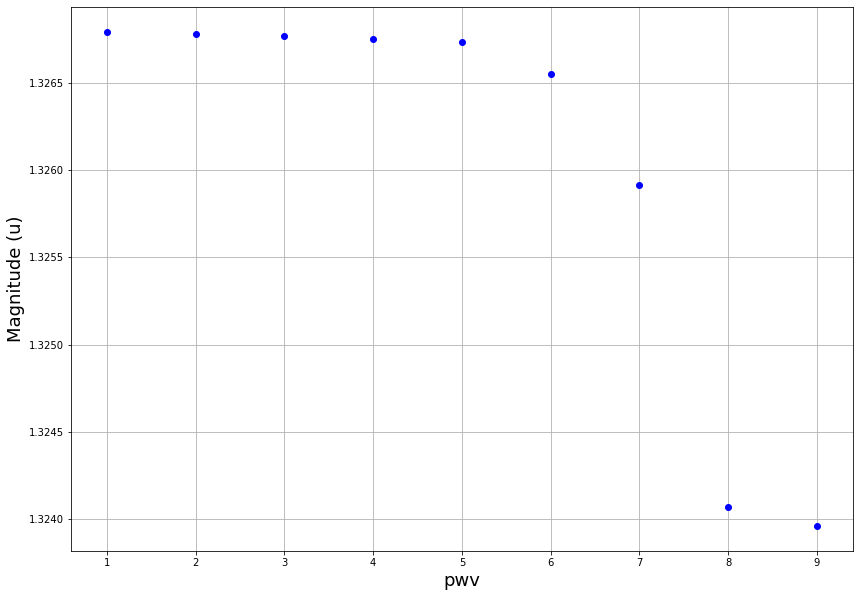

In [91]:
band = 'u'
plt.figure(figsize=(14,10))
plt.plot(atm_vals,mag_dict[test_type][test_spec][band],ls='',marker='o',color='b',label=band)
plt.grid()
plt.xlabel(variable_param,fontsize=18)
plt.ylabel('Magnitude ({0})'.format(band),fontsize=18)
#plt.legend(loc="best")

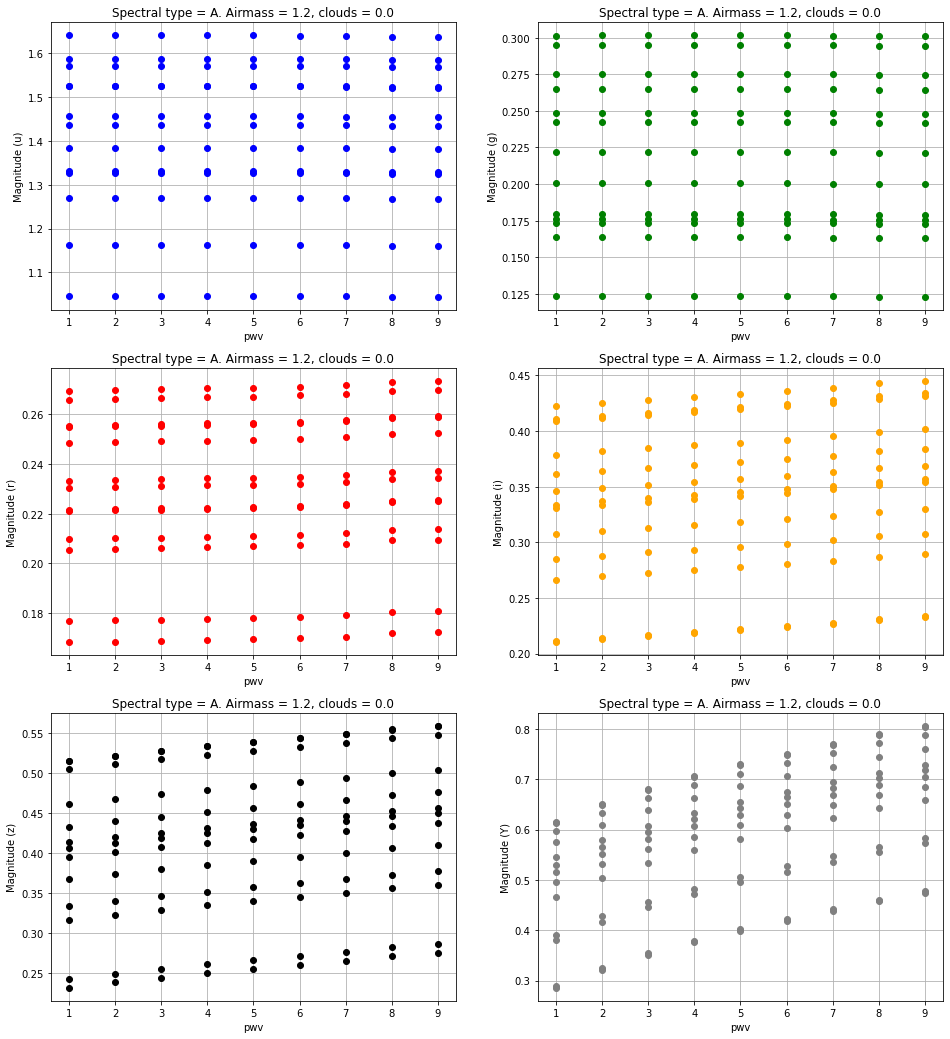

In [92]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters):
            band = filters[i]
            for si in mag_dict[test_type]:
                axs[row,col].plot(atm_vals,mag_dict[test_type][si][band],ls='',marker='o',color=filter_colors[i])
            axs[row,col].grid()
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel('Magnitude ({0})'.format(band))
            axs[row,col].set_title('Spectral type = {0}. Airmass = {1}, clouds = {2}'.format(test_type,am0,cloud0))
            i += 1
            

Now we do the same for the colours: 

Text(0, 0.5, 'u-g')

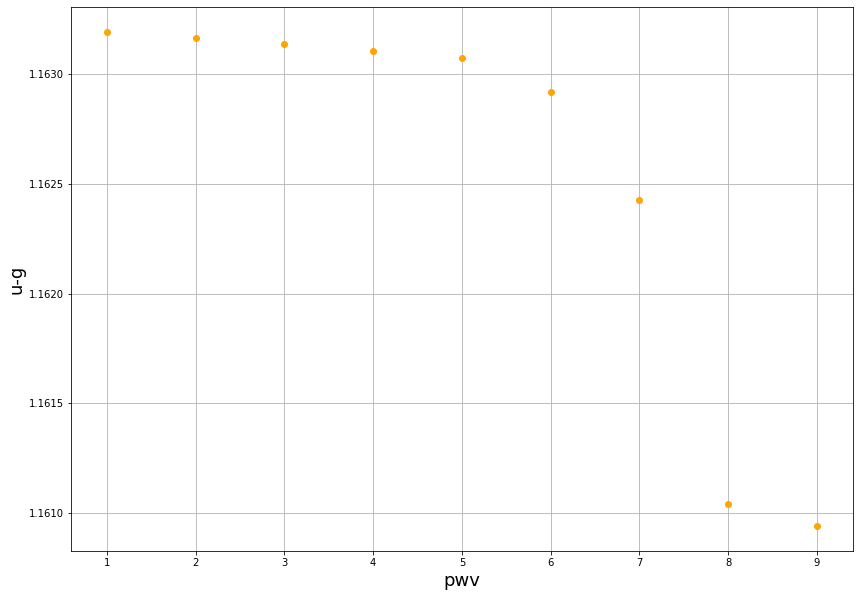

In [93]:
plt.figure(figsize=(14,10))
col = 'u-g'
color_ = colour_dict[test_type][test_spec][col]
plt.plot(atm_vals,color_,ls='',marker='o',color='orange')
plt.grid()
plt.xlabel(variable_param,fontsize=18)
plt.ylabel('{0}'.format(col),fontsize=18)

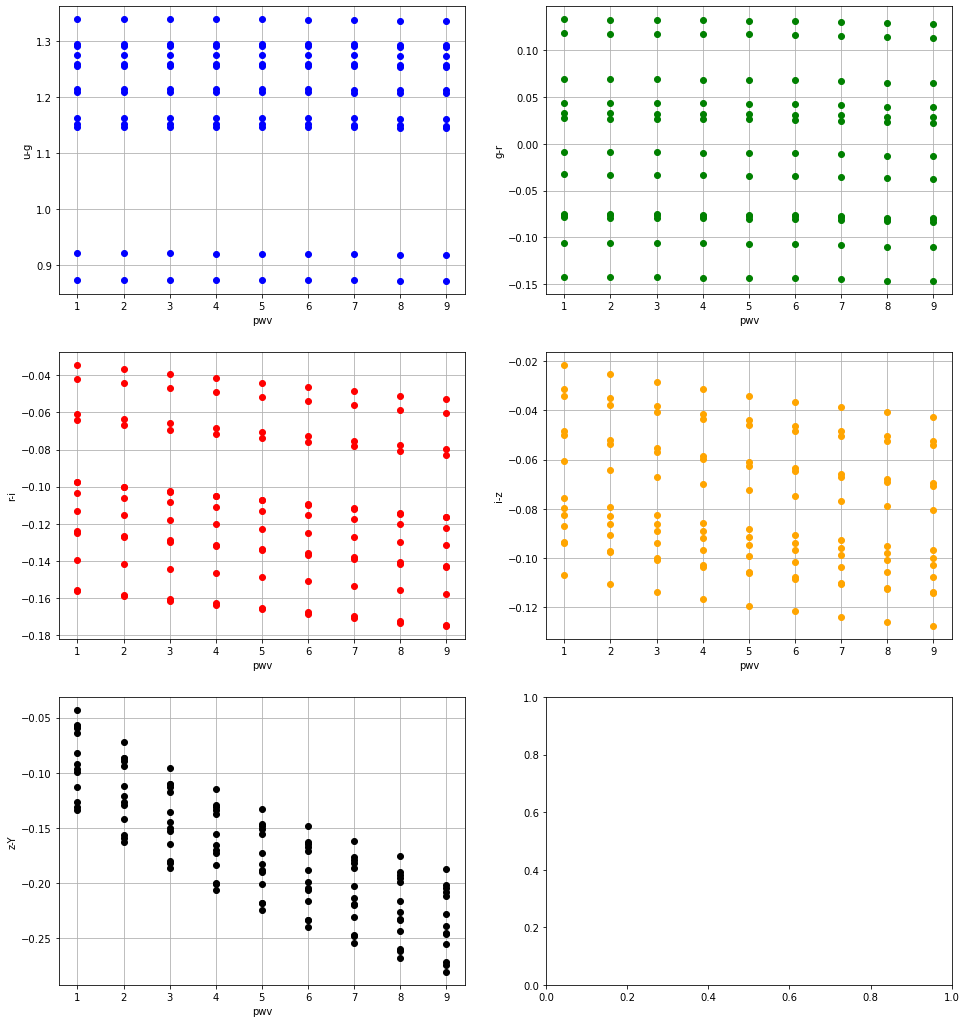

In [94]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-1:
            c = '{0}-{1}'.format(filters[i],filters[i+1])
            for si in colour_dict[test_type]:
                axs[row,col].plot(atm_vals,colour_dict[test_type][si][c.lower()],ls='',marker='o',color=filter_colors[i])
            axs[row,col].grid()
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel(c)
            #axs[row,col].legend()
            i += 1

Doing the same but with respect to the reference atmosphere, that is, $\Delta c = c - c_{ref}$: 

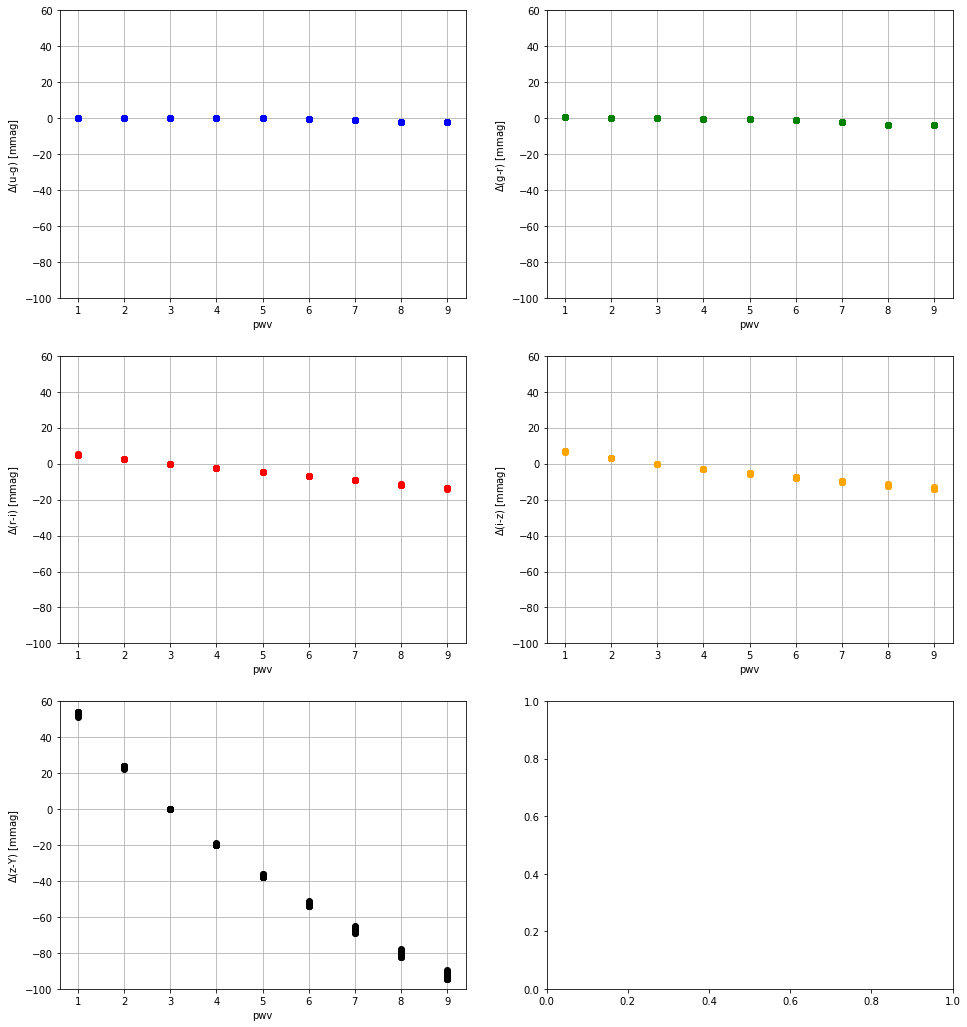

In [95]:
fig_rows = 3
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-1:
            c = '{0}-{1}'.format(filters[i],filters[i+1])
            for si in range(len(colour_dict[test_type])):
                #if si not in [15,16,17,18]:
                axs[row,col].plot(atm_vals,(colour_dict[test_type][si][c.lower()]-colour_dict_ref[test_type][si][c.lower()])*1000.,ls='',marker='o',color=filter_colors[i])
            
            axs[row,col].grid()
            axs[row,col].set_ylim(-100,60)
            axs[row,col].set_xlabel(variable_param)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+c+') [mmag]')
            #axs[row,col].legend()
            i += 1

# Evaluate the colour - colour plot as a function of the atmospheric parameter values 

Let's check first with the example spectrum: 

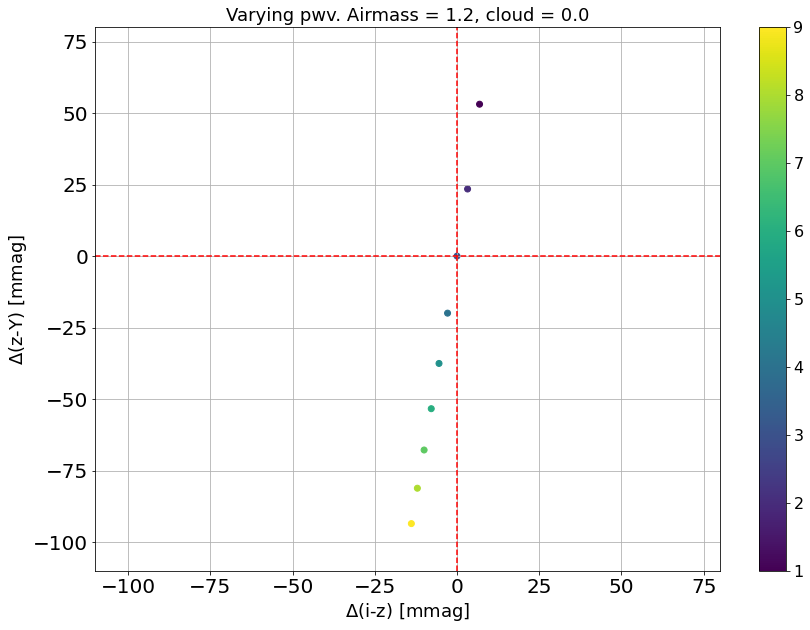

In [96]:
colorx = 'i-z'
colory = 'z-Y'
plt.figure(figsize=(14,10))
delta1 = (colour_dict[test_type][test_spec][colorx.lower()]-colour_dict_ref[test_type][test_spec][colorx.lower()])*1000.
delta2 = (colour_dict[test_type][test_spec][colory.lower()]-colour_dict_ref[test_type][test_spec][colory.lower()])*1000.
plt.scatter(delta1,delta2,c=atm_vals)
plt.axhline(y=0.,ls='--',color='r')
plt.axvline(x=0.,ls='--',color='r')
plt.grid()
plt.xlim(-110,80)
plt.ylim(-110,80)
#plt.xticks(fontsize=20,rotation=45,ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.title('Varying {0}. Airmass = {1}, cloud = {2}'.format(variable_param,am0,cloud0),fontsize=18)
plt.savefig(outdir_plots+'example_spectrum_colour_colour_plot_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0))

Select Delta_color ranges 

In [97]:
rangex = (-110,80)
rangey = (-110,80)

Now we evaluate the colour - colour plot for all spectra of the example spectral type: 

In [98]:
save_plot = True

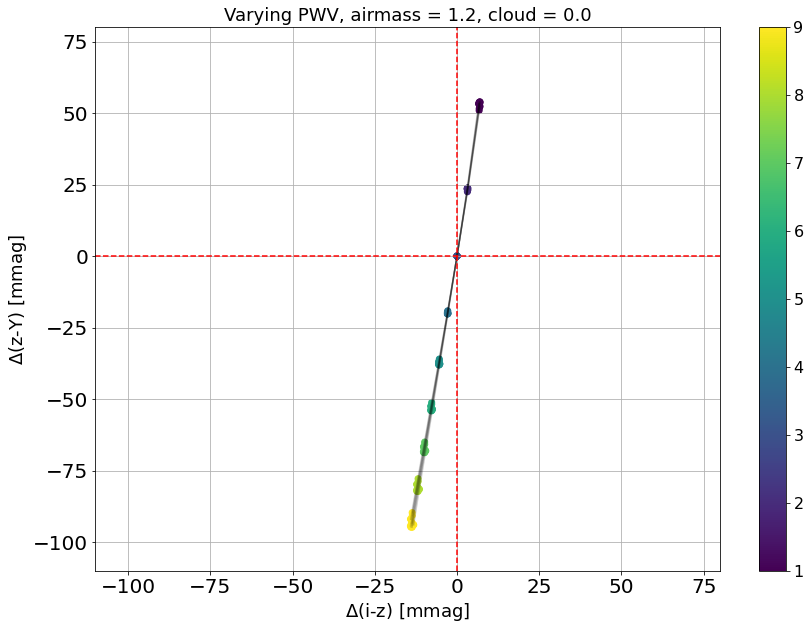

In [99]:
colorx = 'i-z'
colory = 'z-Y'
plt.figure(figsize=(14,10))
for si in colour_dict[test_type]:
    delta1 = (colour_dict[test_type][si][colorx.lower()]-colour_dict_ref[test_type][si][colorx.lower()])*1000.
    delta2 = (colour_dict[test_type][si][colory.lower()]-colour_dict_ref[test_type][si][colory.lower()])*1000.
    plt.plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
    plt.scatter(delta1,delta2,c=atm_vals)
plt.axhline(y=0.,ls='--',color='r')
plt.axvline(x=0.,ls='--',color='r')
plt.grid()
plt.xlim(rangex)
plt.ylim(rangey)
#plt.xticks(fontsize=20,rotation=45,ha='right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
plt.ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=16)
#plt.title('Spectral type: {0}. Number of spectra = {1}'.format(test_type,len(colour_dict[test_type].keys())),fontsize=16)
if save_plot:
    if variable_param=='airmass' or variable_param=='cloud':
        plt.title('Varying {0}'.format(variable_param.upper()),fontsize=18)
    else:
        plt.title('Varying {0}, airmass = {1}, cloud = {2}'.format(variable_param.upper(),am0,cloud0),fontsize=18)
    if variable_param=='airmass' or variable_param=='cloud':
        plt.savefig(outdir_plots+'spectral_type_{0}_colour_colour_plot_varying{1}.png'.format(test_type,variable_param))
    else:
        plt.savefig(outdir_plots+'spectral_type_{0}_colour_colour_plot_{1}_airmass_{2}_cloud_{3}.png'.format(test_type,variable_param,am0,cloud0))


Let's evaluate the same colour - colour plot for the different spectral types: 

O
B
A
F
G
K
M


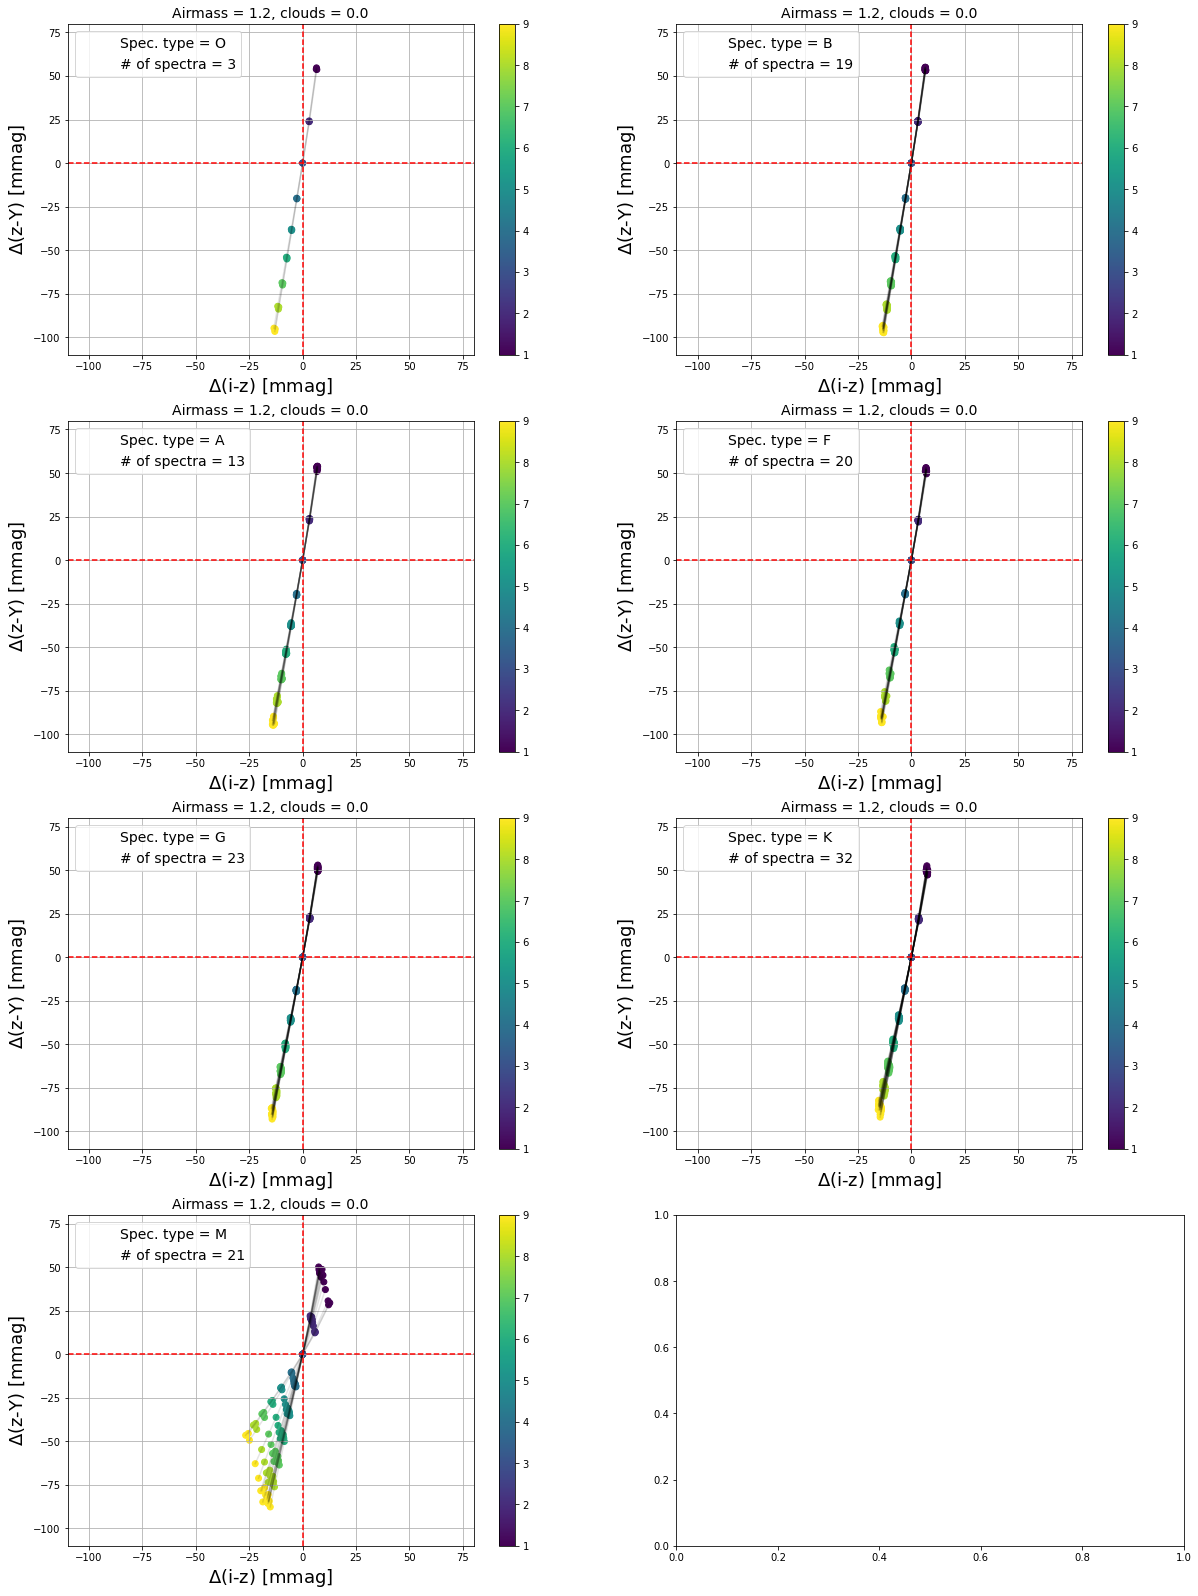

In [100]:
colorx = 'i-z'
colory = 'z-Y'

fig_rows = 4
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,28))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(spectral_types):
            spec_type = spectral_types[i]
            print(spec_type)
            
            for si in colour_dict[spec_type]:
                delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
                delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
                if si==0:
                    im = axs[row,col].scatter(delta1,delta2,c=atm_vals)
                else:
                    axs[row,col].scatter(delta1,delta2,c=atm_vals)
                axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            axs[row,col].plot([],[],ls='',label='Spec. type = {0}'.format(spec_type))
            axs[row,col].plot([],[],ls='',label='# of spectra = {0}'.format(len(colour_dict[spec_type].keys())))
            axs[row,col].set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1


Now we evaluate the different colour - colour plots for the example spectral type: 

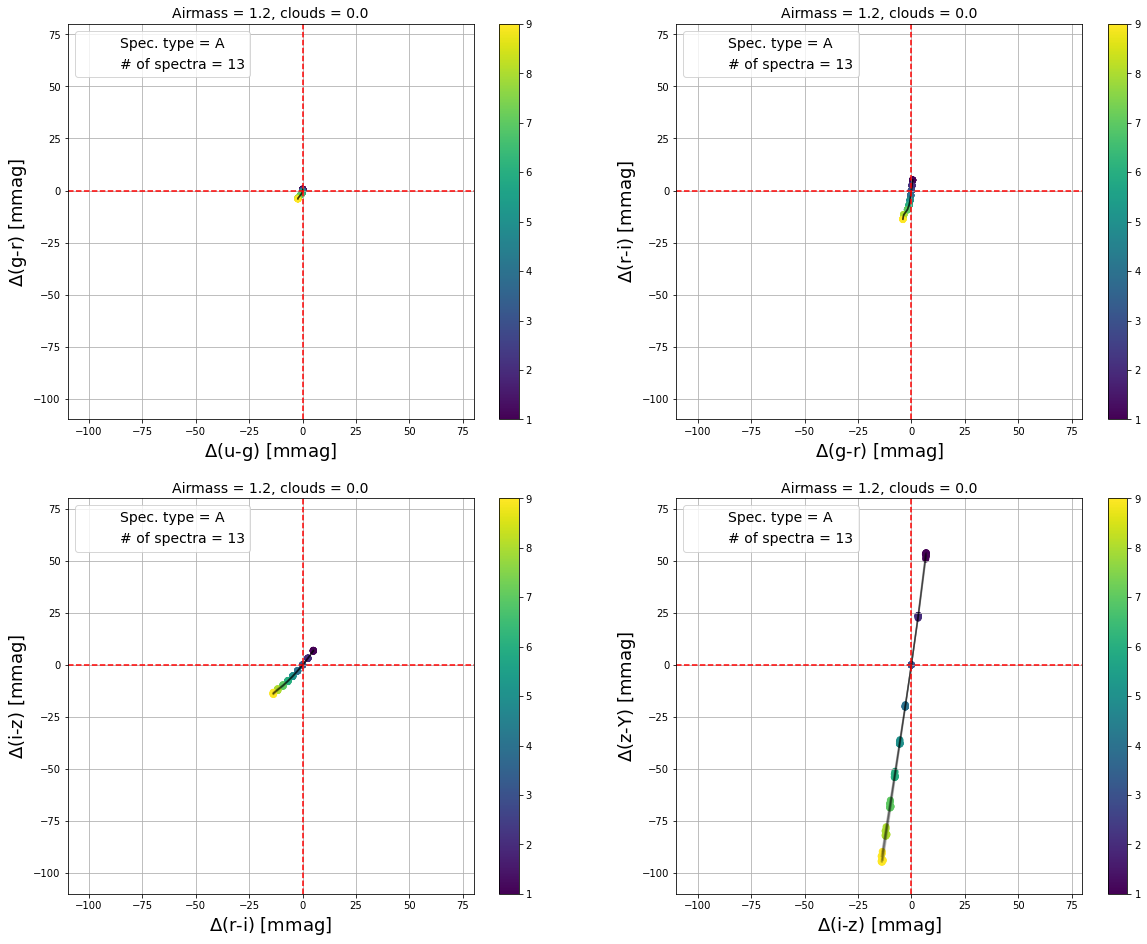

In [101]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for si in colour_dict[test_type]:
                delta1 = (colour_dict[test_type][si][cx.lower()]-colour_dict_ref[test_type][si][cx.lower()])*1000.
                delta2 = (colour_dict[test_type][si][cy.lower()]-colour_dict_ref[test_type][si][cy.lower()])*1000.
                if si==0:
                    im = axs[row,col].scatter(delta1,delta2,c=atm_vals)
                else:
                    axs[row,col].scatter(delta1,delta2,c=atm_vals)
                axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            #axs[row,col].set_xlim(-0.012,0.021)
            #axs[row,col].set_ylim(-0.065,0.126)
            axs[row,col].plot([],[],ls='',label='Spec. type = {0}'.format(test_type))
            axs[row,col].plot([],[],ls='',label='# of spectra = {0}'.format(len(colour_dict[test_type].keys())))
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1

We also evaluate the dependency of the colours with the atmospheric parameters for each spectral type: 

In [102]:
type_markers = {'O':'s','B':'x','A':'o','F':'v','G':'^','K':'P','M':'*'}

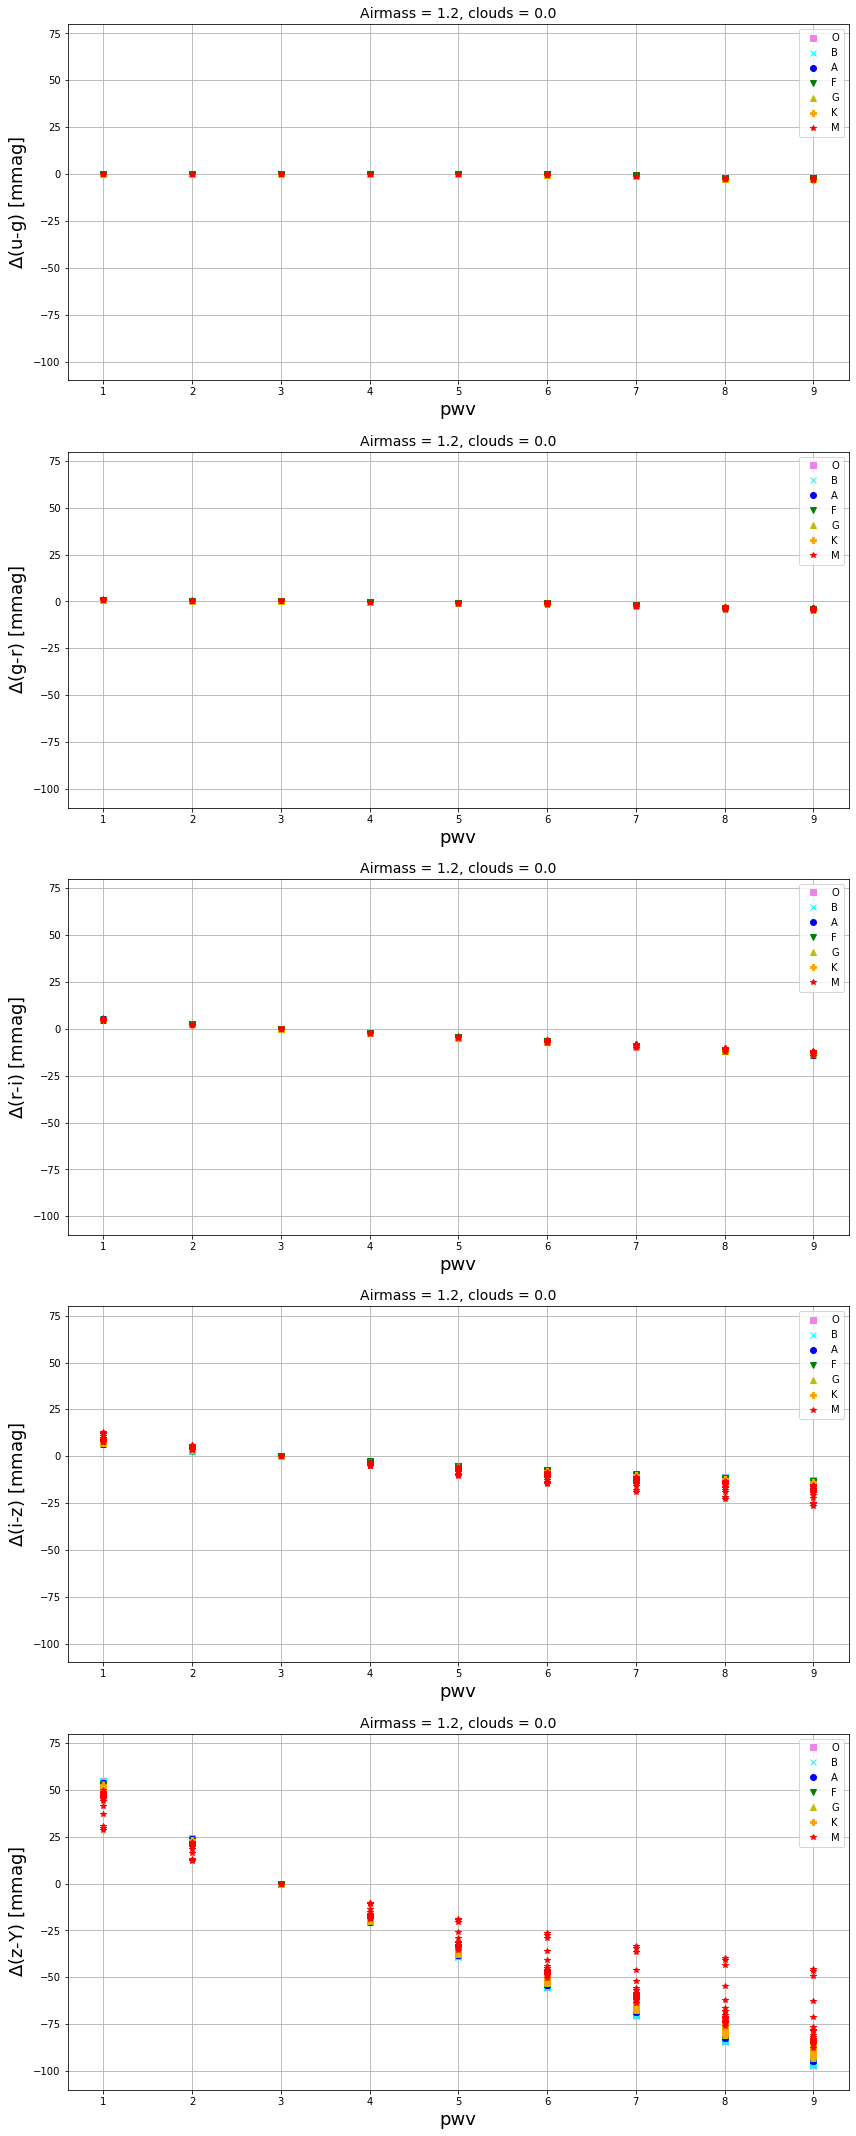

In [103]:
fig_rows = len(filters)-1
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(14,38))
for row in range(fig_rows):
    c = '{0}-{1}'.format(filters[row],filters[row+1])
    for spec_type in spectral_types:
        for si in mag_dict[spec_type]:
            delta_c_ = (colour_dict[spec_type][si][c.lower()]-colour_dict_ref[spec_type][si][c.lower()])*1000.
            axs[row].plot(atm_vals,delta_c_,ls='',marker=type_markers[spec_type],color=type_colors[spec_type])
        axs[row].plot([],[],ls='',marker=type_markers[spec_type],color=type_colors[spec_type],label = spec_type)
    axs[row].set_ylim(rangey)
    axs[row].grid()
    axs[row].set_xlabel(variable_param,fontsize=18)
    axs[row].set_ylabel(r'$\Delta$'+'('+c+') [mmag]',fontsize=18)
    axs[row].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
    axs[row].legend()
plt.savefig(outdir_plots+'delta_colours_vs_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0))
    

Let's have a look now at the colour-colour plots for all spectral types together 

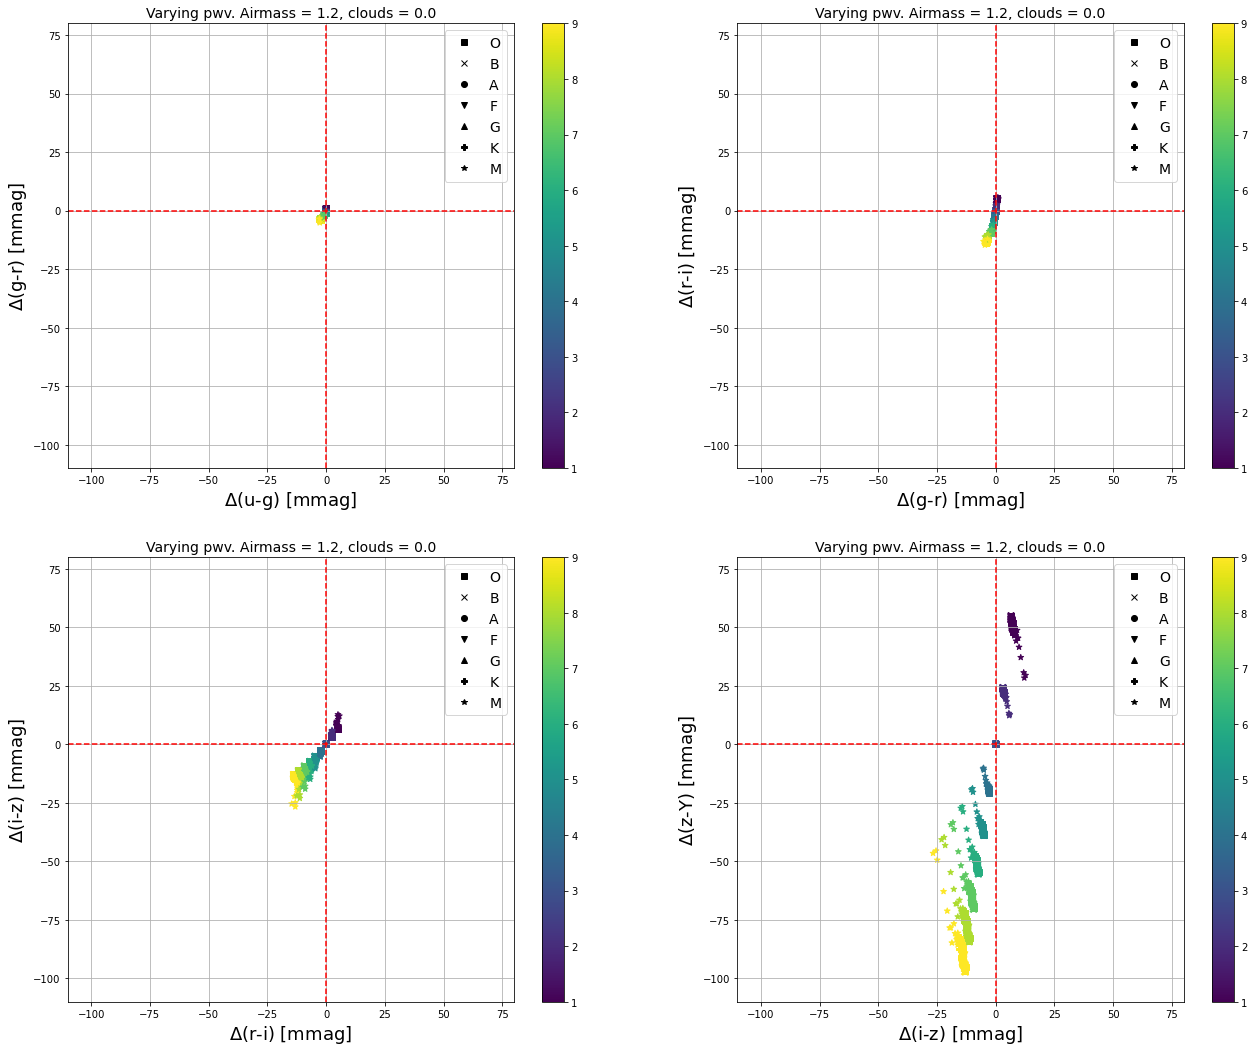

In [104]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(22,18))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    if sed_==0:
                        im = axs[row,col].scatter(delta1,delta2,c=atm_vals,marker=type_markers[spec_type])
                    else:
                        axs[row,col].scatter(delta1,delta2,c=atm_vals,marker=type_markers[spec_type])
                    #axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
                axs[row,col].plot([],[],c='k',ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            plt.colorbar(im, ax=axs[row,col])
            axs[row,col].legend(fontsize=14)
            i += 1
plt.savefig(outdir_plots+'colour_colour_plots_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0))

Now we look at the same information but restricted to the most extreme atmospheric parameter values: 

u
g
r
i
z
Y
photlam


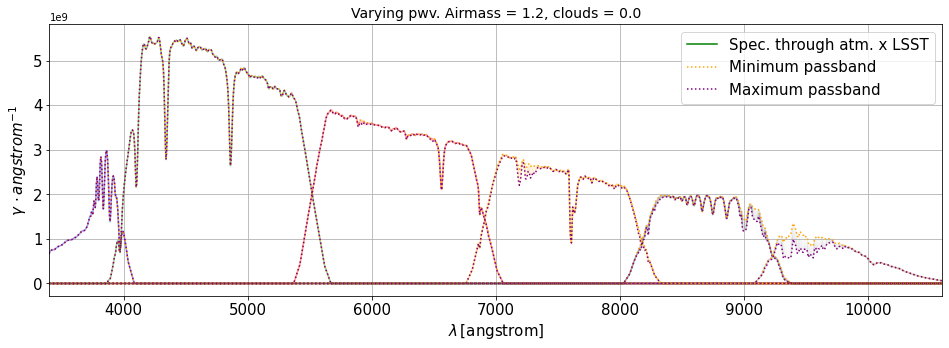

In [105]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

for index,filter in enumerate(obstotal_dict.keys()):
    print(filter)
    for obs in obstotal_dict[filter]:
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.05)
    ax.plot(obstotal_dict[filter][min_ind_].binwave,obstotal_dict[filter][min_ind_].binflux*Seff*exptime,ls=':',color='orange')
    ax.plot(obstotal_dict[filter][max_ind_].binwave,obstotal_dict[filter][max_ind_].binflux*Seff*exptime,ls=':',color='purple')
plt.xlim(WLMIN,WLMAX)
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.grid()
plt.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')
plt.plot([],[],ls=':',color='orange',label='Minimum passband')
plt.plot([],[],ls=':',color='purple',label='Maximum passband')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
plt.savefig(outdir_plots+'example_spectrum_min_max_total_passband_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0))
print(spec.fluxunits)

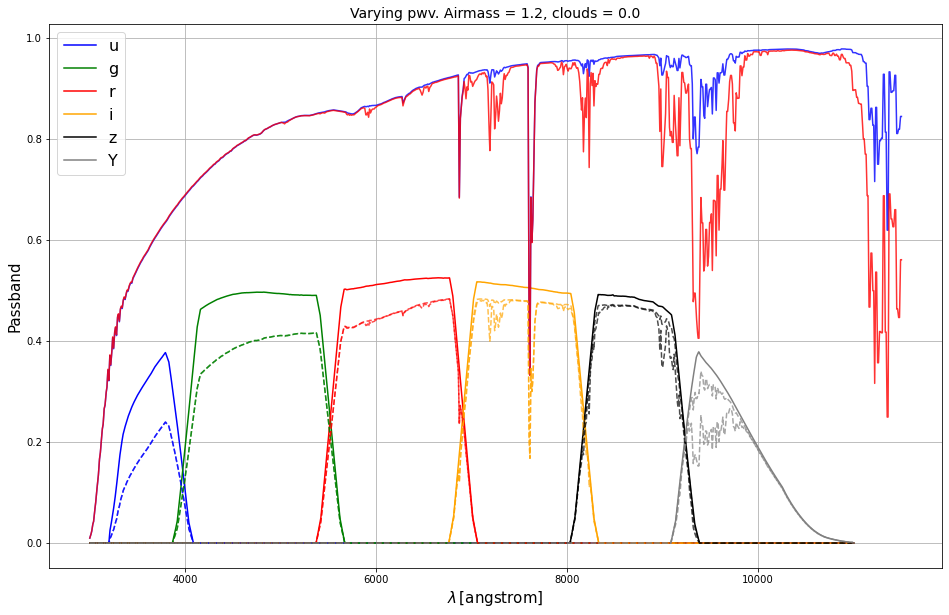

In [106]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

ax.plot(atm_transp[min_ind_].wave,atm_transp[min_ind_].throughput,alpha=0.8,color='b')
ax.plot(atm_transp[max_ind_].wave,atm_transp[max_ind_].throughput,alpha=0.8,color='r')

for index,bpname in enumerate(filters):
    ax.plot(total_passband[bpname][min_ind_].wave,total_passband[bpname][min_ind_].throughput,ls='--',color=filter_colors[index],alpha=0.7)
    ax.plot(total_passband[bpname][max_ind_].wave,total_passband[bpname][max_ind_].throughput,ls='--',color=filter_colors[index],alpha=0.7)        
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(atm_transp_ref.waveunits)+']',fontsize=15)
plt.ylabel('Passband',fontsize=15)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
plt.savefig(outdir_plots+'total_passbands_min_max_varying_{0}_airmass_{1}_cloud_{2}.png'.format(variable_param,am0,cloud0))
plt.legend(fontsize=16)

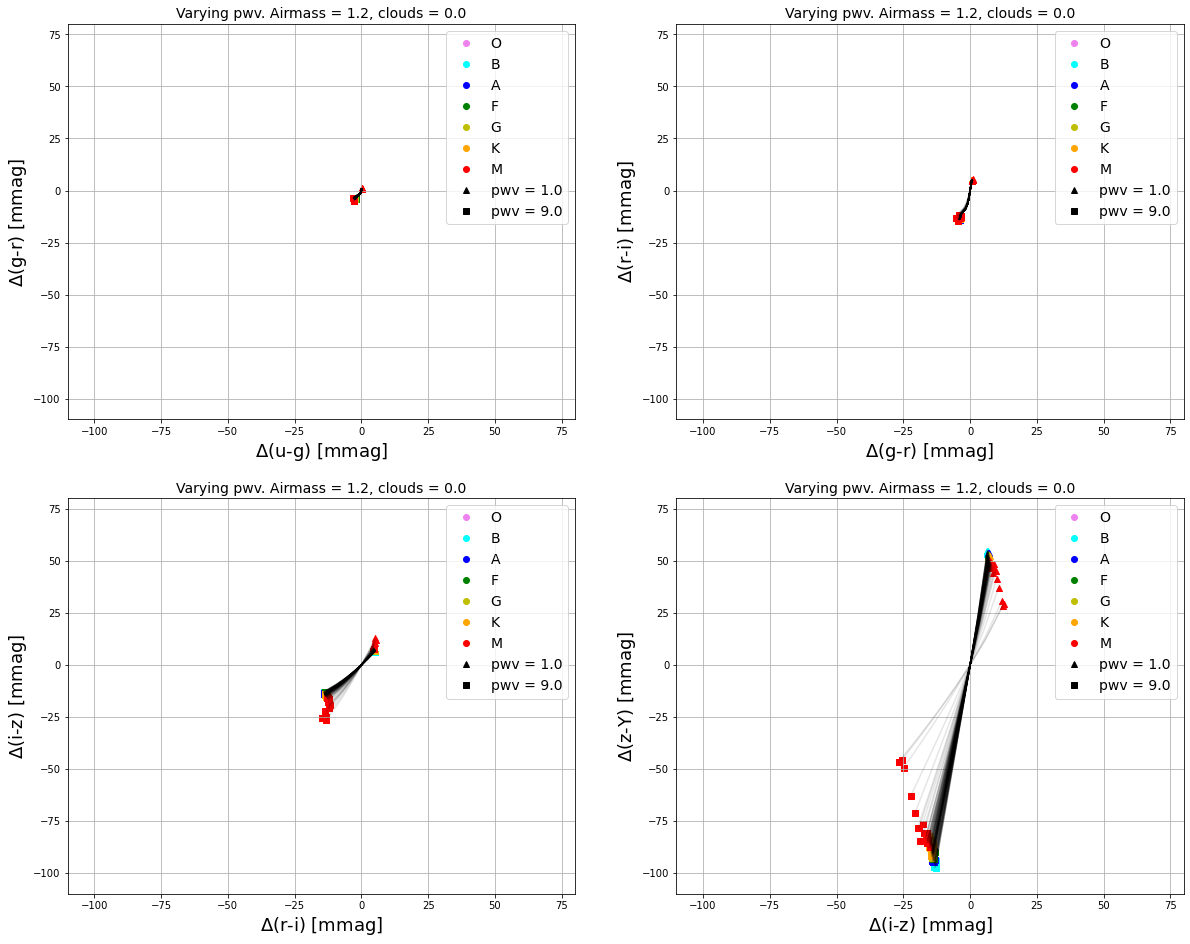

In [107]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    delta1_min = (colour_dict[spec_type][si][cx.lower()][min_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_min = (colour_dict[spec_type][si][cy.lower()][min_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    delta1_max = (colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_max = (colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    axs[row,col].scatter(delta1_min,delta2_min,c=type_colors[spec_type],marker='^')
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker='s')
                    axs[row,col].plot(delta1,delta2,ls='-',marker='',color='k',alpha=0.1)
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
            axs[row,col].plot([],[],ls='',marker='^',color='k',label='{0} = {1}'.format(variable_param,atm_vals[min_ind_]))
            axs[row,col].plot([],[],ls='',marker='s',color='k',label='{0} = {1}'.format(variable_param,atm_vals[max_ind_]))
            #axs[row,col].axhline(y=0.,ls='--',color='r')
            #axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            #axs[row,col].set_xlim(-21.,33.)
            axs[row,col].set_xlim(rangex)
            axs[row,col].set_ylim(rangey)
            
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
    
            i += 1

plt.savefig(outdir_plots+'colour_colour_plots_min_max_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0))

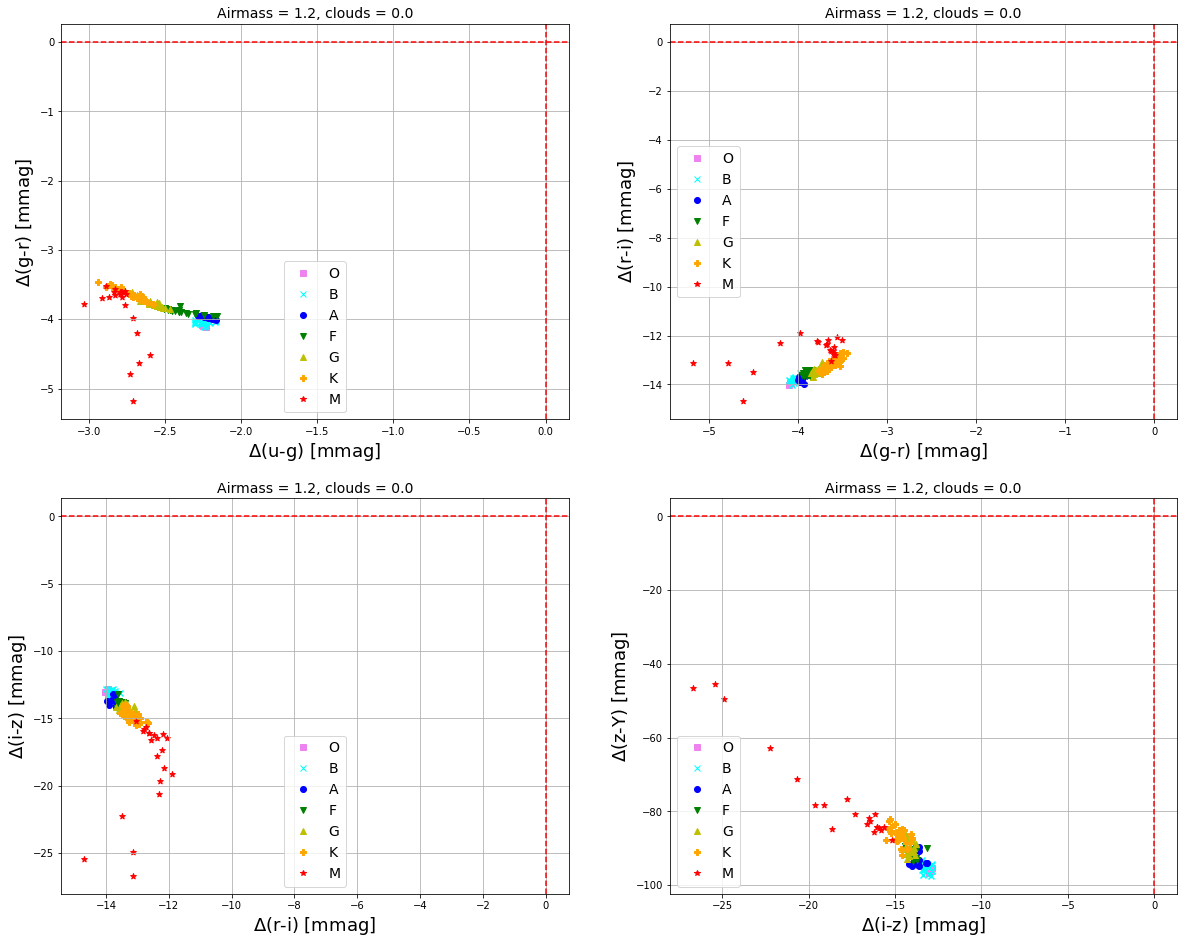

In [108]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types:
                for si in colour_dict[spec_type]:
                    delta1_max = (colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
                    delta2_max = (colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
                    
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker=type_markers[spec_type])
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
            
            i += 1

We exclude the M type spectra for more clarity: 

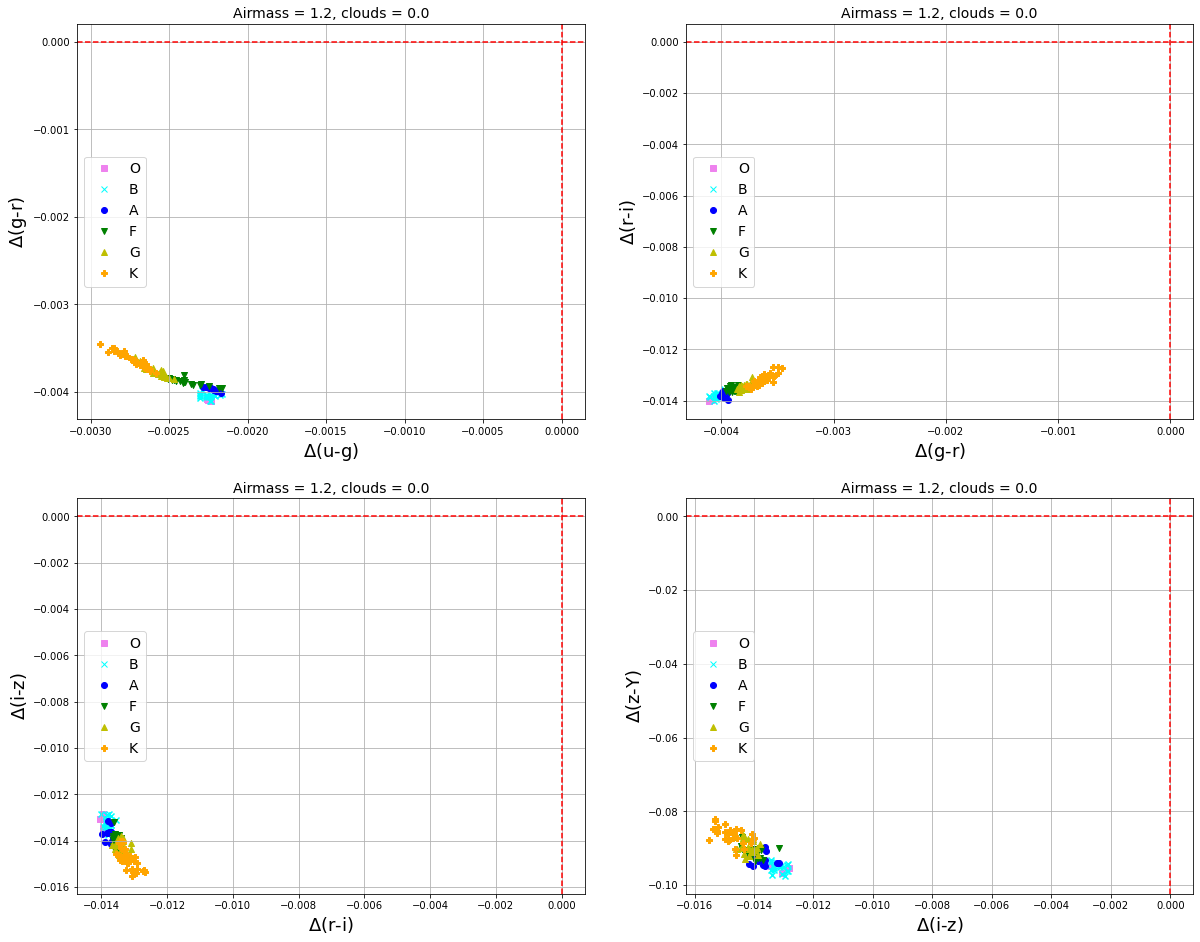

In [109]:
fig_rows = 2
fig_cols = 2
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,16))
i = 0
for row in range(fig_rows):
    for col in range(fig_cols):
        if i<len(filters)-2:
            cx = '{0}-{1}'.format(filters[i],filters[i+1])
            cy = '{0}-{1}'.format(filters[i+1],filters[i+2])
            
            for spec_type in spectral_types[:-1]:
                for si in colour_dict[spec_type]:
                    delta1_max = colour_dict[spec_type][si][cx.lower()][max_ind_]-colour_dict_ref[spec_type][si][cx.lower()]
                    delta2_max = colour_dict[spec_type][si][cy.lower()][max_ind_]-colour_dict_ref[spec_type][si][cy.lower()]
                    
                    axs[row,col].scatter(delta1_max,delta2_max,c=type_colors[spec_type],marker=type_markers[spec_type])
                axs[row,col].plot([],[],c=type_colors[spec_type],ls='',marker=type_markers[spec_type],label=spec_type)
            axs[row,col].axhline(y=0.,ls='--',color='r')
            axs[row,col].axvline(x=0.,ls='--',color='r')
            axs[row,col].grid()
            #axs[row,col].set_xticks(fontsize=20)
            #axs[row,col].set_yticks(fontsize=20)
            
            axs[row,col].set_xlabel(r'$\Delta$'+'('+cx+')',fontsize=18)
            axs[row,col].set_ylabel(r'$\Delta$'+'('+cy+')',fontsize=18)
            axs[row,col].set_title('Airmass = {0}, clouds = {1}'.format(am0,cloud0),fontsize=14)
            axs[row,col].legend(fontsize=14)
            
            i += 1

# Make 3D colour plot 

To see an interactive version of the following plot, see notebook "03_spectrum_ThroughAtmLSST_3Dcolor_plot.ipynb" 

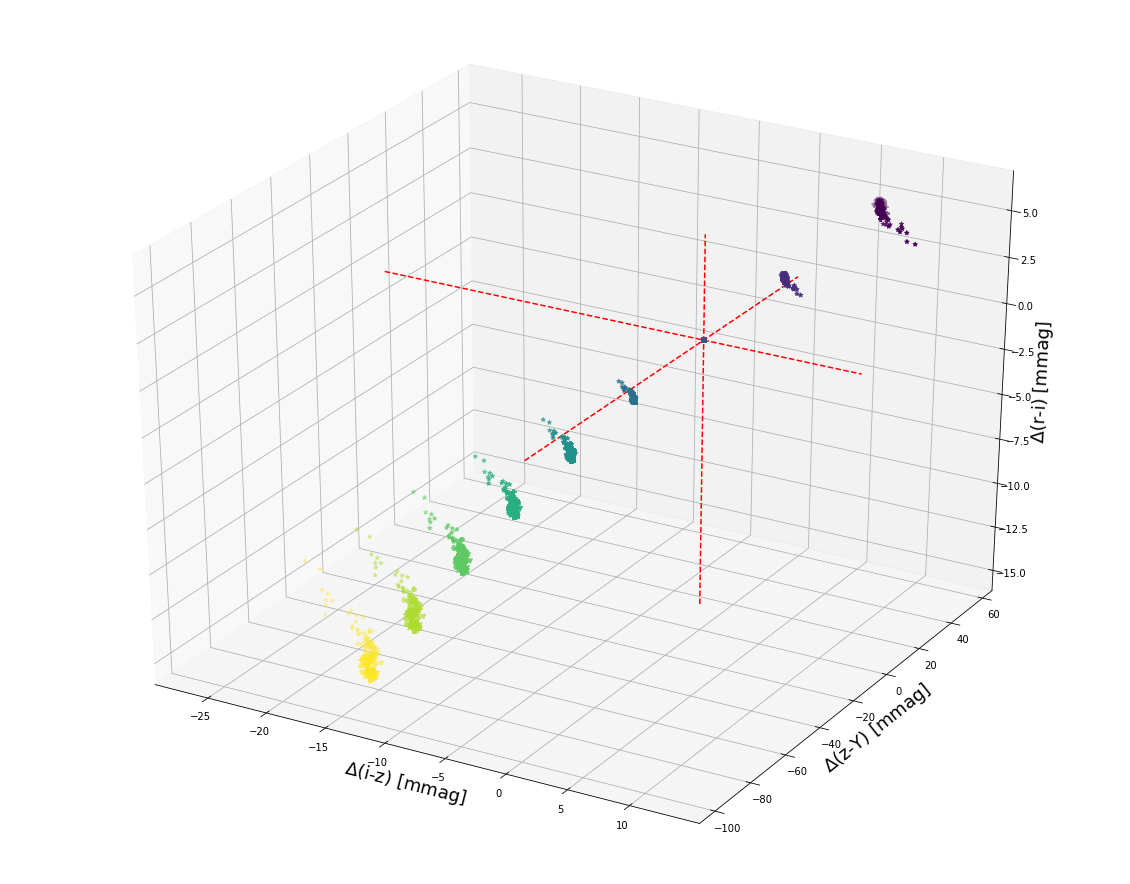

In [110]:
colorx = 'i-z'
colory = 'z-Y'
colorz = 'r-i'

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(projection='3d')

minx, maxx = [], []
miny, maxy = [], []
minz, maxz = [], []
for spec_type in spectral_types:
    for si in colour_dict[spec_type]:
        delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
        delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
        delta3 = (colour_dict[spec_type][si][colorz.lower()]-colour_dict_ref[spec_type][si][colorz.lower()])*1000.

        ax.scatter(delta1,delta2,delta3,c=atm_vals,marker=type_markers[spec_type])
        minx.append(np.min(delta1))
        miny.append(np.min(delta2))
        minz.append(np.min(delta3))
        maxx.append(np.max(delta1))
        maxy.append(np.max(delta2))
        maxz.append(np.max(delta3))

ax.set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
ax.set_zlabel(r'$\Delta$'+'('+colorz+') [mmag]',fontsize=18)

xrange = np.linspace(np.min(minx),np.max(maxx),100)
yrange = np.linspace(np.min(miny),np.max(maxy),100)
zrange = np.linspace(np.min(minz),np.max(maxz),100)

ax.plot(xrange,np.zeros(len(yrange)),np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')


# Calculate colour evolution for SNe Ia spectra 

We use the SNe Ia spectra from https://github.com/rhiannonlynne/photometry_sample/tree/main/sn 

In [111]:
sne_path = 'data/SNIa_spectra/'
sn1_data = np.loadtxt(os.path.join(sne_path,'sn1a_10.0.dat'))
sn2_data = np.loadtxt(os.path.join(sne_path,'sn1a_15.0.dat'))
sn3_data = np.loadtxt(os.path.join(sne_path,'sn1a_20.0.dat'))

The wavelengths are in nm and the fluxes in erg/s/cm2/nm, so we need to change the units to angstrom and photlam = #photons/s/cm2/angstrom (pysynphot assumes that the input fluxes are in photlam). For this, we need to remember that the conversion between flam (erg/s/cm2/angstrom) and photlam is given by 

$$ photlam = \frac{\lambda}{h \cdot c} flam $$

In [112]:
sn1wave = sn1_data[:,0]*10.
sn2wave = sn2_data[:,0]*10.
sn3wave = sn3_data[:,0]*10.

sn1flux = sn1_data[:,1]*sn1wave/(h_planck*c_light)
sn2flux = sn2_data[:,1]*sn2wave/(h_planck*c_light)
sn3flux = sn3_data[:,1]*sn3wave/(h_planck*c_light)

In [119]:
sn1 = S.ArraySpectrum(sn1wave,sn1flux,name='sn1a_10.0')
sn2 = S.ArraySpectrum(sn2wave,sn2flux,name='sn1a_15.0')
sn3 = S.ArraySpectrum(sn3wave,sn3flux,name='sn1a_20.0')

In [120]:
sn1.waveunits, sn1.fluxunits

(<pysynphot.units.Angstrom at 0x7f7f8d5dd340>,
 <pysynphot.units.Photlam at 0x7f7f97fa05e0>)

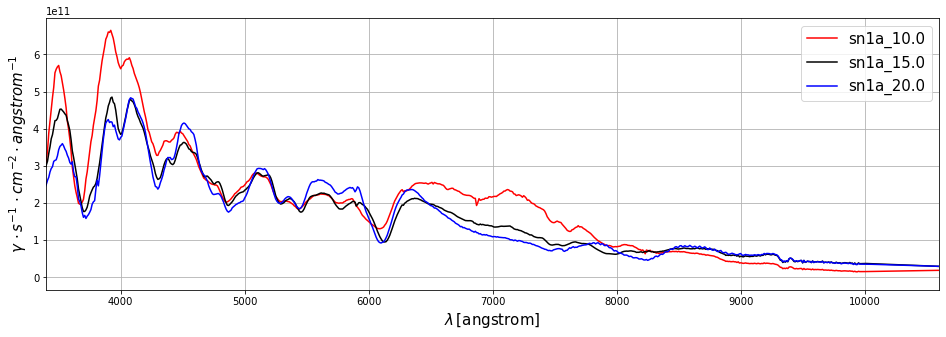

In [130]:
fig=plt.figure(figsize=(16,5))
plt.plot(sn1.wave,sn1.flux,color='r',label=sn1.name)
plt.plot(sn2.wave,sn2.flux,color='k',label=sn2.name)
plt.plot(sn3.wave,sn3.flux,color='b',label=sn3.name)
plt.xlim(WLMIN,WLMAX)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot s^{-1} \, \cdot cm^{-2} \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=15)

Now we pass the SNIa spectra through the total passbands, as with the calibration spectra 

In [131]:
sn_list = [sn1,sn2,sn3]

In [132]:
# SNe Ia through atm x throughput 
sn_obs_dict = {}
for si,spec in enumerate(sn_list):
    filter_dict_ = {}
    for filter in filters:
        filter_dict_[filter] = []
        for i in range(n_sim):
            obs_spec = S.Observation(spec,total_passband[filter][i],force='taper')
            filter_dict_[filter].append(obs_spec)
    sn_obs_dict[si] = filter_dict_ 


((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

In [143]:
print(len(sn_obs_dict.keys()))
print(len(sn_obs_dict[0].keys()))
print(len(sn_obs_dict[0]['u']))

3
6
9


In [146]:
# SNe Ia only through throughput (as if telescope was in space) 
sn_obs_dict_t = {}
for si,spec in enumerate(sn_list):
    filter_dict_ = {}
    for filter in lsst_bp:
        obs_spec_t = S.Observation(spec,filter,force='taper')
        filter_dict_[filter.name] = obs_spec_t
    sn_obs_dict_t[si] = filter_dict_ 
    

(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(Y) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in

In [150]:
print(len(sn_obs_dict_t.keys()))
print(len(sn_obs_dict_t[0].keys()))
print(sn_obs_dict_t[0]['u'].flux)

3
6
[ 0.  0.  0. ... nan nan nan]


Text(0.5, 1.0, 'Varying pwv. Airmass = 1.2, clouds = 0.0')

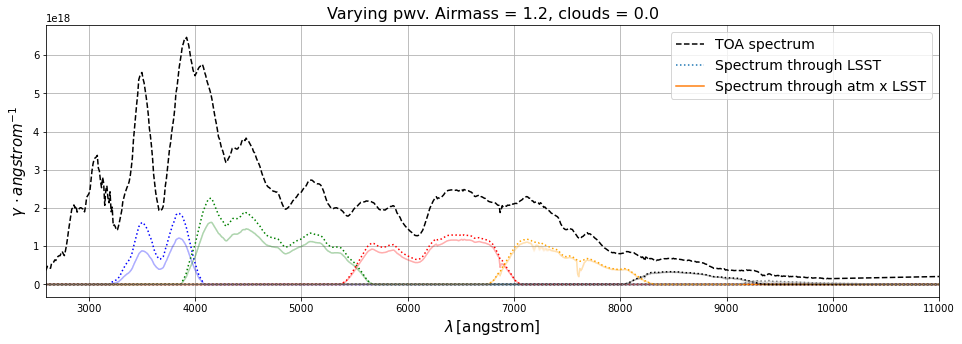

In [159]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(sn_list[0].wave,sn_list[0].flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(sn_obs_dict_t[0][filter].wave,sn_obs_dict_t[0][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = sn_obs_dict[0][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.04)
    
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(2600.,11000.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)

We zoom in to see the effect of the different atmospheric transparencies 

Text(0.5, 1.0, 'Varying pwv. Airmass = 1.2, clouds = 0.0')

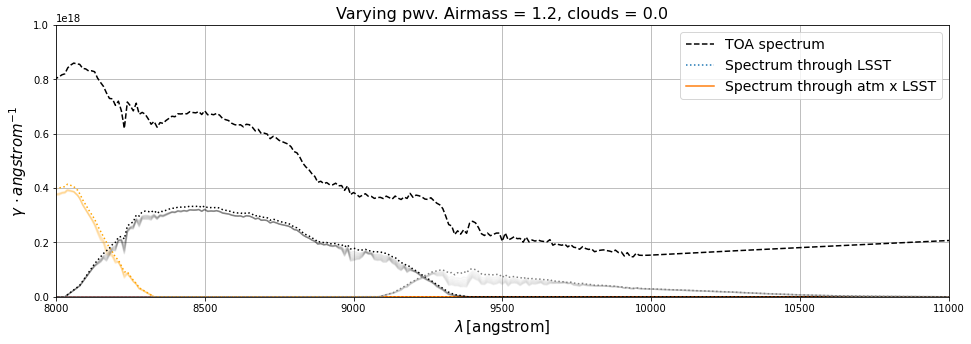

In [162]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
plt.plot(sn_list[0].wave,sn_list[0].flux*Seff*exptime,ls='--',color='k',label='TOA spectrum')

for index,filter in enumerate(filters):
    #plt.plot(obs_dict_t[example_spec][filter].wave,obs_dict_t[example_spec][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    plt.plot(sn_obs_dict_t[0][filter].wave,sn_obs_dict_t[0][filter].flux*Seff*exptime,ls=':',color=filter_colors[index])
    
    for i in range(n_sim):
        #obs_ = obs_dict[example_spec][filter][i]
        obs_ = sn_obs_dict[0][filter][i]
        #plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.02)
        plt.plot(obs_.wave,obs_.flux*Seff*exptime,ls='-',color=filter_colors[index],alpha=0.07)
    
plt.plot([],[],ls=':',label='Spectrum through LSST')
plt.plot([],[],ls='-',label='Spectrum through atm x LSST')
plt.xlim(8000.,11000.)
plt.ylim(0,1e18)
plt.grid()
plt.xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
plt.ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.legend(fontsize=14)
plt.title('Varying {0}. Airmass = {1}, clouds = {2}'.format(variable_param,am0,cloud0),fontsize=16)

We can now calculate the magnitudes and colours 

In [161]:
# Magnitudes of spectra passing through atm x throughput 
sn_mag_dict = {}
sn_mag_dict_ref = {}
for si,obs_spec_ in enumerate(sn_list):
    mag_dict_ = {}
    mag_dict_ref_ = {}
    for fi,filter in enumerate(filters):
        mag_dict_[filter] = []
        for i in range(n_sim):
            #mag_dict_[filter].append(obs_spec_[filter][i].effstim("abmag"))
            mag_ab_ = myAB(obs_spec_,total_passband[filter][i],lsst_bp[fi])
            mag_dict_[filter].append(mag_ab_)
            
        #mag_dict[sed_] = mag_dict_
        
        mag_ab_ = myAB(obs_spec_,total_passband_ref[filter],lsst_bp[fi])
        mag_dict_ref_[filter] = mag_ab_
    sn_mag_dict[si] = mag_dict_
    sn_mag_dict_ref[si] = mag_dict_ref_

ATTENTION: converting flux units to flam
((u * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.478758025423094
ATTENTION: converting flux units to flam
((u * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.478768893864263
ATTENTION: converting flux units to flam
((u * Atm. transp. 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(u) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.47878161751223
ATTENTION: converting flux units to flam
((u * Atm. transp. 4)) does not have a defined binset in the wavecat table. Th

(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.839804940195272
ATTENTION: converting flux units to flam
((z * Atm. transp. 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.83543475191496
ATTENTION: converting flux units to flam
((z * Atm. transp. 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.831143374142528
ATTENTION: converting flux units to flam
((z * Atm. transp. 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(z) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-19.82674003

-20.62733243085818
ATTENTION: converting flux units to flam
((r * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(r) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.630865036596497
ATTENTION: converting flux units to flam
((i * Atm. transp. 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.270226511308277
ATTENTION: converting flux units to flam
((i * Atm. transp. 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(i) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.267176440791317
ATTENTION: converting flux units to flam
((i * Atm. transp. 3)) does not have a defined binset in t

(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.730635397090897
ATTENTION: converting flux units to flam
((g * Atm. transp. 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.731146110743637
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.73115890182192
ATTENTION: converting flux units to flam
((g * Atm. transp. 9)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
(g) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
-20.73046310

In [167]:
print(len(sn_mag_dict.keys()))
print(len(sn_mag_dict[0].keys()))
print(len(sn_mag_dict[0]['u']))

3
6
9


In [169]:
sn_colour_dict = {}
for sn in sn_mag_dict.keys():
    c_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(sn_mag_dict[sn][filters[fi]])
        mag2 = np.array(sn_mag_dict[sn][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
    sn_colour_dict[sn] = c_dict


In [170]:
print(len(sn_mag_dict.keys()))
print(len(sn_colour_dict.keys()))
print(len(sn_colour_dict[0].keys()))
print(len(sn_colour_dict[0]['u-g']))

3
3
5
9


In [172]:
sn_colour_dict_ref = {}
for sn in sn_mag_dict_ref.keys():
    c_dict = {}
    for fi in range(len(filters)-1):
        mag1 = np.array(sn_mag_dict_ref[sn][filters[fi]])
        mag2 = np.array(sn_mag_dict_ref[sn][filters[fi+1]])
        #print(mag1)
        #print(mag2)
        
        colour_ = mag1-mag2
        colour_name = '{0}-{1}'.format(filters[fi].lower(),filters[fi+1].lower())
        c_dict[colour_name] = colour_
    sn_colour_dict_ref[sn] = c_dict
    

In [174]:
print(len(sn_mag_dict_ref.keys()))
print(len(sn_colour_dict_ref.keys()))
print(len(sn_colour_dict_ref[0].keys()))
print(sn_colour_dict_ref[0]['u-g'])

3
3
5
0.34546386375220806


In [175]:
np.save('output_files/sn_colour_dict.npy',sn_colour_dict)
np.save('output_files/sn_colour_dict_ref.npy',sn_colour_dict_ref)

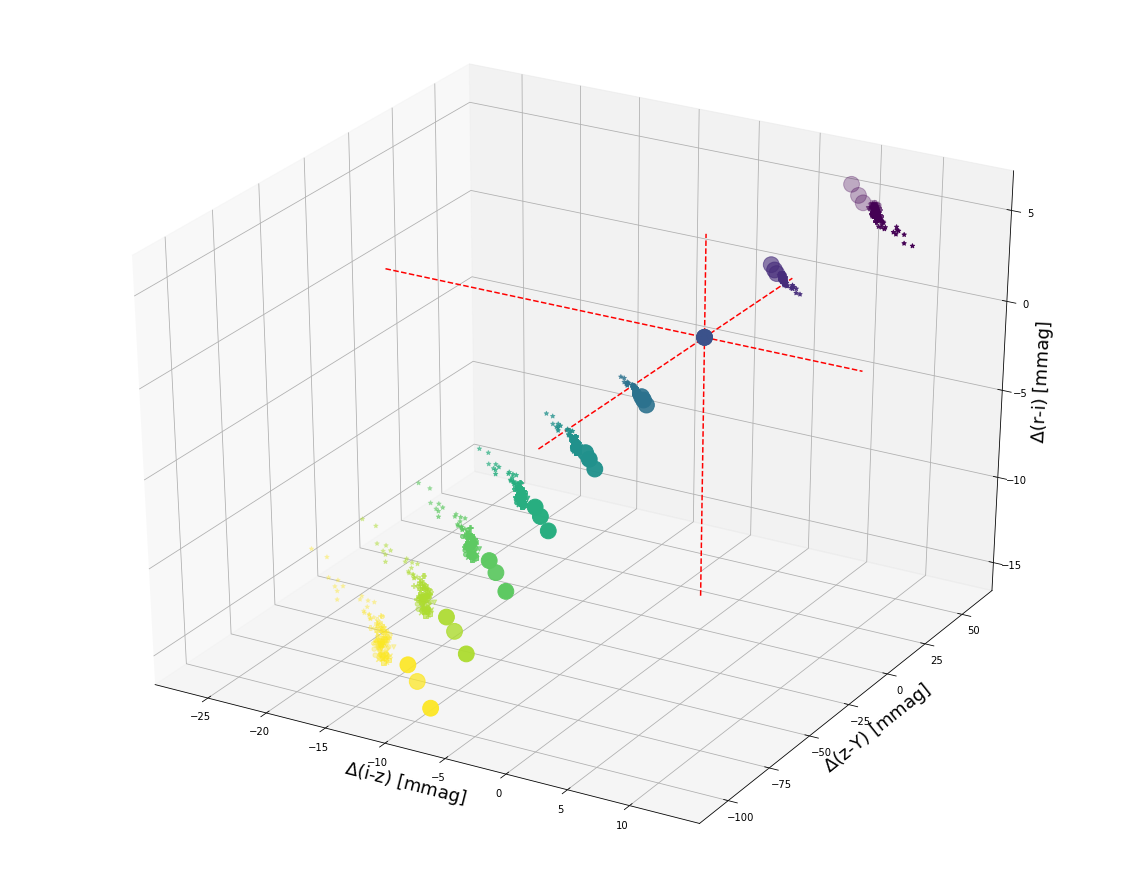

In [189]:
colorx = 'i-z'
colory = 'z-Y'
colorz = 'r-i'

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(projection='3d')

minx, maxx = [], []
miny, maxy = [], []
minz, maxz = [], []
for spec_type in spectral_types:
    for si in colour_dict[spec_type]:
        delta1 = (colour_dict[spec_type][si][colorx.lower()]-colour_dict_ref[spec_type][si][colorx.lower()])*1000.
        delta2 = (colour_dict[spec_type][si][colory.lower()]-colour_dict_ref[spec_type][si][colory.lower()])*1000.
        delta3 = (colour_dict[spec_type][si][colorz.lower()]-colour_dict_ref[spec_type][si][colorz.lower()])*1000.

        ax.scatter(delta1,delta2,delta3,c=atm_vals,marker=type_markers[spec_type])
        minx.append(np.min(delta1))
        miny.append(np.min(delta2))
        minz.append(np.min(delta3))
        maxx.append(np.max(delta1))
        maxy.append(np.max(delta2))
        maxz.append(np.max(delta3))
        
for sn in sn_colour_dict.keys():
    delta1_sn = (sn_colour_dict[sn][colorx.lower()]-sn_colour_dict_ref[sn][colorx.lower()])*1000.
    delta2_sn = (sn_colour_dict[sn][colory.lower()]-sn_colour_dict_ref[sn][colory.lower()])*1000.
    delta3_sn = (sn_colour_dict[sn][colorz.lower()]-sn_colour_dict_ref[sn][colorz.lower()])*1000.
    
    ax.scatter(delta1_sn,delta2_sn,delta3_sn,c=atm_vals,marker='o',s=250.0)

ax.set_xlabel(r'$\Delta$'+'('+colorx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+colory+') [mmag]',fontsize=18)
ax.set_zlabel(r'$\Delta$'+'('+colorz+') [mmag]',fontsize=18)

xrange = np.linspace(np.min(minx),np.max(maxx),100)
yrange = np.linspace(np.min(miny),np.max(maxy),100)
zrange = np.linspace(np.min(minz),np.max(maxz),100)

ax.plot(xrange,np.zeros(len(yrange)),np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),yrange,np.zeros(len(zrange)),'r--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')
